# Capstone Project - The Battle of Neighbourhoods 
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

### Background
Cologne is Germany's fourth biggest city and has about 1 million inhabitants. It's located in the west of Germany, not far from the Dutch border. It's on the left bank of the river Rhine. Its famous Cathedral (Kölner Dom) is the seat of the Catholic Archbishop of Cologne and Cologne's landmark known internationally. Germany's only sport university is in Cologne and the Cologne Bonn Airport is Germany's seventh-largest airport.
I live in Cologne, that's why I choose Cologne for this final assignment. 
### Problem
The apartment market of Cologne has become really rough and it's hard to find an affordable apartment in one of the popular neighbourhoods. However, often the neighbourhoods are only popular and expensive because of their reputation. The infrastructure of other neighbourhoods within Cologne might be pretty similar and offer a similar living experience, but with cheaper apartment prices. 
### Interest
For people that either move to Cologne or look for a new apartment within Cologne (e.g. when moving together with a partner) it's interesting to find alternatives to the popular and expensive neighbourhoods. Therefore, I compare and cluster the neighbourhoods to show potential alternatives and give some guidance to apartment-hunters in Cologne.

## Data <a name="data"></a>

### Preparation
At first, I import all the relevant libraries.

**Note:** I use a docker environment with an image that already contains all relevant packages, hence I don't need to install them.

In [1]:
import pandas as pd
import numpy as np
import requests
import io

import json # library to handle JSON files
from geopy.geocoders import Nominatim 
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry.polygon import LinearRing
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

import folium # map rendering library

print("All libraries imported :) Let's go!")

All libraries imported :) Let's go!


### Data acquisition and cleaning
#### Data sources
I basically use two data sources:
1. Open data provided by the city of Cologne itself: https://offenedaten-koeln.de. This page offers many data sets on all different kinds of information. It also offers vast geodata on Cologne's neighbourhoods including polygons of coordinates for each neighbourhood and socio-economic data on households, inhabitants, schools etc. per neighbourhood.
2. I will use the Foursquare API to get data on all different kinds of venues within each neighbourhood of Cologne to reflect the infrastructure of a neighbourhood with regard to restaurants, gyms, supermarkets and other categories. **Note: The assignment requires the usage of Foursquare. Otherwise, I would not use Foursquare because it's not so popular in Germany (or at least in Cologne) and I feel that it doesn't cover a lot of the venues.** 

##### 1. Location data for all neighbourhoods

In [2]:
# request the geodata from https://offenedaten-koeln.de/dataset/stadtteile

geodata = json.loads(requests.get('https://geoportal.stadt-koeln.de/arcgis/rest/services/Stadtgliederung_15/MapServer/1/query?where=objectid+is+not+null&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=4326&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&resultOffset=&resultRecordCount=&f=pjson').text)
#geodata


In [3]:
# identify the keys

list(geodata.keys())

['displayFieldName',
 'fieldAliases',
 'geometryType',
 'spatialReference',
 'fields',
 'features']

In [4]:
#Normalize semi-structured JSON data into a flat table on the features

geo = json_normalize(geodata['features'])
geo.head()

attributes.FLAECHE attributes.LINK attributes.NAME  \
0             4592631            None          Godorf   
1             3692013            None        Lövenich   
2             3654710            None          Weiden   
3             7376623            None     Junkersdorf   
4             5599212            None     Widdersdorf   

  attributes.NR_STADTBEZIRK attributes.NUMMER  attributes.OBJECTID  \
0                         2               211                    7   
1                         3               308                    8   
2                         3               307                    9   
3                         3               306                   10   
4                         3               309                   11   

  attributes.STADTBEZIRK                                     geometry.rings  
0           Rodenkirchen  [[[6.994359341598065, 50.85835989408827], [6.9...  
1             Lindenthal  [[[6.835101297207516, 50.957260493877406], [6....  
2             Lindenthal  [[[6.849501526802686, 50.94220412958467], [6.8...  
3             Lindenthal  [[[6.854198181651118, 50.94052346246431], [6.8...  
4             Lindenthal  [[[6.851763526592514, 50.97718504868292], [6.8...

The default names of the columns are not very handy, therefore I'll rename them accordingly. Furthermore, there are some columns that I don't need at all (e.g. attributes.LINK or attributes.NR_STADTBEZIRK). These will be dropped.

In [5]:
# drop irrelevant columns

geo.drop(['attributes.LINK'], 1, inplace = True)
geo.drop(['attributes.NR_STADTBEZIRK'], 1, inplace = True)
geo.drop(['attributes.OBJECTID'], 1, inplace = True)

# rename columns

geo.rename(columns = {"attributes.FLAECHE": "sqm","attributes.NAME":"neighbourhood", "attributes.NUMMER":"no.", 
                      "attributes.STADTBEZIRK":"borough"}, inplace = True)

# check dataframe
geo.head()


sqm neighbourhood  no.       borough  \
0  4592631        Godorf  211  Rodenkirchen   
1  3692013      Lövenich  308    Lindenthal   
2  3654710        Weiden  307    Lindenthal   
3  7376623   Junkersdorf  306    Lindenthal   
4  5599212   Widdersdorf  309    Lindenthal   

                                      geometry.rings  
0  [[[6.994359341598065, 50.85835989408827], [6.9...  
1  [[[6.835101297207516, 50.957260493877406], [6....  
2  [[[6.849501526802686, 50.94220412958467], [6.8...  
3  [[[6.854198181651118, 50.94052346246431], [6.8...  
4  [[[6.851763526592514, 50.97718504868292], [6.8...

In [6]:
# check the dataframe and its datatypes

geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
sqm               86 non-null int64
neighbourhood     86 non-null object
no.               86 non-null object
borough           86 non-null object
geometry.rings    86 non-null object
dtypes: int64(1), object(4)
memory usage: 3.4+ KB


The column "no." is an object, but should be an integer. I'll adjust that.

In [7]:
geo['no.'] = geo['no.'].astype('int')
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
sqm               86 non-null int64
neighbourhood     86 non-null object
no.               86 non-null int64
borough           86 non-null object
geometry.rings    86 non-null object
dtypes: int64(2), object(3)
memory usage: 3.4+ KB


**Getting the coordinates of the neighbourhoods: centroid of coordinates polygon**

The geo dataframe contains a polygon of coordinates for each neighbourhood. I will be using the centroid of each polygon as **the** coordinates of the neighbourhood.

For this step, I will be using the LinearRing constructor and cetroid method from the Shapely package.

However, the polygon in the geo dataframe is formatted as a nested list which cannot be processed by the LinearRing constructor. Therefore, I'll remove one nested list and transform the column "geometry.rings".

In [8]:
# remove outer list of column

geo['geometry.rings'] = geo['geometry.rings'].map(lambda x: x[0])

In [9]:
# insert two new columns for latitude and longitude, made out of the centroid of the polygon per neighbourhood

geo.insert(len(geo.columns), 'latitude', geo['geometry.rings'].map(lambda coords: LinearRing(coords).centroid.y)) 
geo.insert(len(geo.columns), 'longitude', geo['geometry.rings'].map(lambda coords: LinearRing(coords).centroid.x))

# check dataframe
geo.head()

sqm neighbourhood  no.       borough  \
0  4592631        Godorf  211  Rodenkirchen   
1  3692013      Lövenich  308    Lindenthal   
2  3654710        Weiden  307    Lindenthal   
3  7376623   Junkersdorf  306    Lindenthal   
4  5599212   Widdersdorf  309    Lindenthal   

                                      geometry.rings   latitude  longitude  
0  [[6.994359341598065, 50.85835989408827], [6.99...  50.853612   6.981604  
1  [[6.835101297207516, 50.957260493877406], [6.8...  50.948982   6.830322  
2  [[6.849501526802686, 50.94220412958467], [6.84...  50.935889   6.829889  
3  [[6.854198181651118, 50.94052346246431], [6.85...  50.923522   6.859912  
4  [[6.851763526592514, 50.97718504868292], [6.85...  50.964576   6.843137

In [10]:
geo.shape

(86, 7)

The constructors of the Shapely library usually expect geographical coordinates in the order of: latitude, longitude.

However, the coordinates of the geometry ring are in the order: longitude, latitude.

Therefore, I'll swap them to be able to easily use the Shapely library for my analysis.

In [11]:
def swap_coord(coord):
    return [coord[1], coord[0]]

def swap_coords(coord_list):
    return list(map(swap_coord, coord_list))

geo['geometry.rings'] = geo['geometry.rings'].apply(swap_coords)

Since the neighbourhoods in Cologne have official neighbourhood numbers (see column "no."), I'm sorting the data according to the official neighbourhood number and reset the index.

In [12]:
# sort data by no.
geo = geo.sort_values(by = ['no.'])

# reset index
geo = geo.reset_index(drop = True)

# check data
geo.head()

sqm  neighbourhood  no.     borough  \
0  2361133   Altstadt/Süd  101  Innenstadt   
1  2863967   Neustadt/Süd  102  Innenstadt   
2  2455273  Altstadt/Nord  103  Innenstadt   
3  3489554  Neustadt/Nord  104  Innenstadt   
4  5239821          Deutz  105  Innenstadt   

                                      geometry.rings   latitude  longitude  
0  [[50.936798424501795, 6.940278401301003], [50....  50.930223   6.953587  
1  [[50.93748386396194, 6.9264717966942015], [50....  50.926103   6.946810  
2  [[50.95008808829535, 6.9589532284153925], [50....  50.942170   6.954201  
3  [[50.95928768013307, 6.9636858833452315], [50....  50.948038   6.948013  
4  [[50.94948568775351, 6.981916500484012], [50.9...  50.938282   6.980676

To get a first impression on Cologne and how the neighbourhoods are distributed, I'll have a look at the map:

In [13]:
# getting coordinates of Cologne
address = 'Cologne, Germany'
geolocator = Nominatim(user_agent = "cologne_explorer")
location_cologne = geolocator.geocode(address)
latitude_cologne = location_cologne.latitude
longitude_cologne = location_cologne.longitude

# create map of Cologne
map_cologne = folium.Map(location=[latitude_cologne, longitude_cologne], zoom_start = 10)

# add markers to map
for lat, lng, neighbourhood in zip(geo['latitude'], geo['longitude'], geo['neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#FF4500',
        fill_opacity = 0.5,
        parse_html = False).add_to(map_cologne)

# show map
map_cologne

![](image.png)

##### 2. Socio-economic data for all neighbourhoods
To reflect the socio-economic state of each neighbourhood I will use the following data:
1. number of day nurseries in each neighbourhood
2. number of schools in each neighbourhood
3. number of registered cars in each neighbourhood
4. different indicators on households in each neighbourhood (e.g. single, couples, with children, without children etc.)
5. unemployment rates in each neighbourhood (e.g. rate of ALG1 or HARTZ4 receivers (that's two different kinds of unemployment money), female, male ones etc.)
6. inhabitants structure in each neighbourhood (e.g. rate of people per age group, per nationality etc.)

In [14]:
# request the geodata
# https://offenedaten-koeln.de/dataset/kindertagesst%C3%A4tten-k%C3%B6ln

nursery = json.loads(requests.get('https://geoportal.stadt-koeln.de/arcgis/rest/services/Stadtplanthemen/MapServer/9/query?geometry=&geometryType=esriGeometryPoint&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&objectIds=&where=objectid%20is%20not%20null&time=&returnCountOnly=false&returnIdsOnly=false&returnGeometry=true&maxAllowableOffset=&outSR=4326&outFields=%2A&f=json').text)
#nursery

In [15]:
#Normalize semi-structured JSON data into a flat table on the features

nursery_data = json_normalize(nursery['features'])
nursery_data.head()

attributes.ADRESSE attributes.NR_STADTBEZIRK  \
0  Immendorfer Hauptstraße 22                         2   
1       Peter-Röser-Straße 35                         4   
2       Rather Schulstraße 18                         8   
3             Rheinaustraße 3                         1   
4          Rheinsteinstraße 4                         2   

  attributes.NR_STADTTEIL  attributes.OBJECTID attributes.POSTZUSTELLBEZIRK  \
0                     212                 4865                        50997   
1                     406                 4866                        50827   
2                     808                 4867                        51107   
3                     101                 4868                        50676   
4                     203                 4869                        50968   

  attributes.STADTBEZIRK attributes.STADTTEIL attributes.TRAEGER_TYP  \
0           Rodenkirchen            Immendorf              städtisch   
1              Ehrenfeld            Ossendorf              städtisch   
2                   Kalk          Rath/Heumar              städtisch   
3             Innenstadt         Altstadt/Süd              städtisch   
4           Rodenkirchen            Raderberg              städtisch   

   geometry.x  geometry.y  
0    6.957222   50.859753  
1    6.913198   50.968268  
2    7.080394   50.920879  
3    6.960587   50.931854  
4    6.960326   50.906630

In [16]:
# clean data: rename columns accordingly and drop not needed columns

nursery_data.rename(columns = {"attributes.ADRESSE" : "day nurseries",
                               "attributes.STADTTEIL" : "neighbourhood"}, inplace = True)

nursery_data = nursery_data.drop(nursery_data.columns.difference(["day nurseries", "neighbourhood"]), axis = 1)

In [17]:
# how many day nurseries per neighbourhood

nursery_data = nursery_data.groupby('neighbourhood').count()

In [18]:
nursery_data.head()

day nurseries
neighbourhood                 
Altstadt/Nord                9
Altstadt/Süd                12
Bayenthal                    7
Bickendorf                  12
Bilderstöckchen              9

In [19]:
nursery_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Altstadt/Nord to Zündorf
Data columns (total 1 columns):
day nurseries    85 non-null int64
dtypes: int64(1)
memory usage: 1.3+ KB


The dataframe contains only 85 neighbourhoods and not 86. Obviously, there is one neighbourhood without a day nursery. I'll set the day nurseries value for that neighbourhood to zero in the next step.

In [20]:
# merge back together

geo = geo.merge(nursery_data, on = 'neighbourhood', how = 'outer')

# replace nan with 0

geo = geo.fillna(value = 0)

In [21]:
geo.shape

(86, 8)

In [22]:
# request the geodata
# https://offenedaten-koeln.de/dataset/schulen-k%C3%B6ln

schools = json.loads(requests.get('https://geoportal.stadt-koeln.de/arcgis/rest/services/Stadtplanthemen/MapServer/6/query?text=&geometry=&geometryType=esriGeometryPoint&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&objectIds=&where=objectid+is+not+null&time=&returnCountOnly=false&returnIdsOnly=false&returnGeometry=true&maxAllowableOffset=&outSR=4326&outFields=*&f=json').text)
#schools


In [23]:
#Normalize semi-structured JSON data into a flat table on the features

school_data = json_normalize(schools['features'])
school_data.head()

attributes.ADRESSE                   attributes.NAME  \
0             Lindenstr. 78  Berufskolleg an der Lindenstraße   
1         Neufelder Str. 32                Hilde-Domin-Schule   
2  Albert-Schweitzer-Str. 8            Otto-Lilienthal-Schule   
3           Humboldtstr. 81                  Don-Bosco-Schule   
4           Pfälzer Str. 30                      Pfälzer Str.   

  attributes.NR_STADTBEZIRK attributes.NR_STADTTEIL  attributes.OBJECTID  \
0                         1                     102                 4538   
1                         9                     904                 4539   
2                         7                     711                 4540   
3                         7                     706                 4541   
4                         1                     102                 4542   

  attributes.POSTZUSTELLBEZIRK attributes.SCHULART attributes.SCHULNAME  \
0                        50674        Berufskolleg                 None   
1                        51067   Schule für Kranke                 None   
2                        51147          Realschule                 None   
3                        51145         Grundschule                 None   
4                        50677         Grundschule                 None   

       attributes.SCHULSTRASSE attributes.SCHULTYP attributes.STADTBEZIRK  \
0             Lindenstr.  (BK)       berufsbildend             Innenstadt   
1          Neufelder Str. (SK)    allgemeinbildend                Mülheim   
2  Albert-Schweitzer-Str. (RS)    allgemeinbildend                   Porz   
3           Humboldtstr. (GGS)    allgemeinbildend                   Porz   
4           Pfälzer Str. (GGS)    allgemeinbildend             Innenstadt   

  attributes.STADTTEIL attributes.TRAEGER  geometry.x  geometry.y  
0         Neustadt/Süd         Stadt Köln    6.933669   50.932865  
1             Holweide         Stadt Köln    7.055747   50.966257  
2                 Wahn         Stadt Köln    7.088293   50.864573  
3                 Porz         Stadt Köln    7.070194   50.887473  
4         Neustadt/Süd         Stadt Köln    6.943521   50.925908

In [24]:
# clean data: rename columns accordingly and drop not needed columns

school_data.rename(columns = {"attributes.NR_STADTTEIL" : "no.",
                               "attributes.SCHULART" : "school type"}, inplace = True)

school_data = school_data.drop(school_data.columns.difference(["no.", "school type"]), axis = 1)

In [25]:
school_data.head()

no.        school type
0  102       Berufskolleg
1  904  Schule für Kranke
2  711         Realschule
3  706        Grundschule
4  102        Grundschule

To be able to analyze the schools per neighbourhood, I'll create dummies for each school type per neighbourhood. The dummy is 1 if the type of school exists and 0 if not.

In [26]:
# one hot encoding
school_data_onehot = pd.get_dummies(school_data[['school type']], prefix = "", prefix_sep = "")

# add column for neighbourhood no. back
school_data_onehot['no.'] = school_data['no.']

school_data_onehot.head()

Berufskolleg  Freie Waldorfschule  Förderschule  Gesamtschule  Grundschule  \
0             1                    0             0             0            0   
1             0                    0             0             0            0   
2             0                    0             0             0            0   
3             0                    0             0             0            1   
4             0                    0             0             0            1   

   Gymnasium  Hauptschule  Realschule  Schule für Kranke  \
0          0            0           0                  0   
1          0            0           0                  1   
2          0            0           1                  0   
3          0            0           0                  0   
4          0            0           0                  0   

   Weiterbildungskolleg  no.  
0                     0  102  
1                     0  904  
2                     0  711  
3                     0  706  
4                     0  102

In [27]:
# group them and get the number of school types per neighbourhood

schools_grouped = school_data_onehot.groupby('no.').sum().reset_index()
schools_grouped.head()

no.  Berufskolleg  Freie Waldorfschule  Förderschule  Gesamtschule  \
0  101             4                    0             2             1   
1  102             3                    1             0             0   
2  103             0                    0             0             0   
3  104             0                    0             1             2   
4  105             4                    0             1             0   

   Grundschule  Gymnasium  Hauptschule  Realschule  Schule für Kranke  \
0            2          3            1           2                  0   
1            5          0            0           0                  0   
2            1          2            0           2                  0   
3            4          2            0           0                  0   
4            2          2            0           1                  0   

   Weiterbildungskolleg  
0                     0  
1                     0  
2                     2  
3                     0  
4                     1

In [28]:
schools_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 11 columns):
no.                     80 non-null object
Berufskolleg            80 non-null uint8
Freie Waldorfschule     80 non-null uint8
Förderschule            80 non-null uint8
Gesamtschule            80 non-null uint8
Grundschule             80 non-null uint8
Gymnasium               80 non-null uint8
Hauptschule             80 non-null uint8
Realschule              80 non-null uint8
Schule für Kranke       80 non-null uint8
Weiterbildungskolleg    80 non-null uint8
dtypes: object(1), uint8(10)
memory usage: 1.5+ KB


In [29]:
# transform 'no.' into integer
schools_grouped['no.'] = schools_grouped['no.'].astype('int')
schools_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 11 columns):
no.                     80 non-null int64
Berufskolleg            80 non-null uint8
Freie Waldorfschule     80 non-null uint8
Förderschule            80 non-null uint8
Gesamtschule            80 non-null uint8
Grundschule             80 non-null uint8
Gymnasium               80 non-null uint8
Hauptschule             80 non-null uint8
Realschule              80 non-null uint8
Schule für Kranke       80 non-null uint8
Weiterbildungskolleg    80 non-null uint8
dtypes: int64(1), uint8(10)
memory usage: 1.5 KB


The dataframe only contains 80 rows, i.e. 80 neighbourhoods. That means, there are 6 neighbourhoods that don't have any school. I'll set the values for these neighbourhoods to 0 in the next step.

In [30]:
# merge back together

geo = geo.merge(schools_grouped, on = 'no.', how = 'outer')

# replace nan with 0

geo = geo.fillna(value = 0)

In [31]:
geo.shape

(86, 18)

In [32]:
# request the geodata
# https://offenedaten-koeln.de/dataset/kfz-statistik-koeln

cars = json.loads(requests.get('https://geoportal.stadt-koeln.de/arcgis/rest/services/Statistische_Daten/QMFS_Kraftfahrzeuge/MapServer/1/query?where=objectid+is+not+null&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=4326&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&resultOffset=&resultRecordCount=&f=geojson').text)
#cars


In [33]:
#Normalize semi-structured JSON data into a flat table on the features

car_data = json_normalize(cars['features'])
car_data.head()

geometry.coordinates geometry.type  id  \
0  [[[7.009698154969715, 50.98762355280711], [7.0...       Polygon  10   
1  [[[6.890423336101029, 50.94649114299174], [6.8...       Polygon  11   
2  [[[6.894022949910494, 50.99503466055852], [6.8...       Polygon  12   
3  [[[7.0547619255228255, 50.895118847617056], [7...       Polygon   1   
4  [[[6.940278401301003, 50.936798424501795], [6....       Polygon   2   

   properties.KFZ_AA  properties.KFZ_AP  properties.KFZ_HA  properties.KFZ_HP  \
0              17580          49.592372              14146          40.719632   
1               7402          70.717493               6449          69.091493   
2               7732          92.921524               6381          84.304400   
3               6283          50.882734               5601          48.217975   
4              11771          46.191579              11434          45.664763   

  properties.NAME properties.NUMMER  properties.OBJECTID  ...  \
0        MÃ¼lheim               901                   10  ...   
1      Braunsfeld               304                   11  ...   
2       Ossendorf               406                   12  ...   
3            Porz               706                    1  ...   
4   Altstadt/SÃ¼d               101                    2  ...   

   properties.PKW_AP  properties.PKW_HA  properties.PKW_HP  \
0          43.171881              12051          34.689119   
1          60.666858               5484          58.752946   
2          73.008052               5138          67.882151   
3          45.602527               5010          43.130165   
4          40.442648              10129          40.452893   

   properties.PRIV_PKW_AA  properties.PRIV_PKW_AP  properties.PRIV_PKW_HA  \
0                   11276               31.809078                   10821   
1                    4650               44.425337                    4065   
2                    3749               45.054681                    3376   
3                    5392               43.666991                    4786   
4                    7168               28.128556                    7096   

   properties.PRIV_PKW_HP  properties.SHAPE.AREA  properties.SHAPE.LEN  \
0               31.148532           7.065807e+06          15388.964696   
1               43.550461           1.680550e+06           8676.896868   
2               44.602986           6.808229e+06          13733.120865   
3               41.201791           3.117291e+06          10466.991259   
4               28.339790           2.361133e+06           8176.733201   

      type  
0  Feature  
1  Feature  
2  Feature  
3  Feature  
4  Feature  

[5 rows x 21 columns]

In [34]:
# clean data: rename columns accordingly and drop not needed columns

car_data.rename(columns = {"properties.NUMMER" : "no.", "properties.KFZ_AP" : "mv rate", 
                           "properties.PKW_AP" : "car rate", "properties.PRIV_PKW_AP" : "p.car rate"}, inplace = True)

car_data = car_data.drop(car_data.columns.difference(["no.", "mv rate", "car rate", "p.car rate"]), axis = 1)

car_data.head()

mv rate  no.   car rate  p.car rate
0  49.592372  901  43.171881   31.809078
1  70.717493  304  60.666858   44.425337
2  92.921524  406  73.008052   45.054681
3  50.882734  706  45.602527   43.666991
4  46.191579  101  40.442648   28.128556

In [35]:
# transform 'no.' into integer
car_data['no.'] = car_data['no.'].astype('int')
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 4 columns):
mv rate       86 non-null float64
no.           86 non-null int64
car rate      86 non-null float64
p.car rate    86 non-null float64
dtypes: float64(3), int64(1)
memory usage: 2.8 KB


In [36]:
geo = geo.merge(car_data, on = 'no.')
geo.head()

sqm  neighbourhood  no.     borough  \
0  2361133   Altstadt/Süd  101  Innenstadt   
1  2863967   Neustadt/Süd  102  Innenstadt   
2  2455273  Altstadt/Nord  103  Innenstadt   
3  3489554  Neustadt/Nord  104  Innenstadt   
4  5239821          Deutz  105  Innenstadt   

                                      geometry.rings   latitude  longitude  \
0  [[50.936798424501795, 6.940278401301003], [50....  50.930223   6.953587   
1  [[50.93748386396194, 6.9264717966942015], [50....  50.926103   6.946810   
2  [[50.95008808829535, 6.9589532284153925], [50....  50.942170   6.954201   
3  [[50.95928768013307, 6.9636858833452315], [50....  50.948038   6.948013   
4  [[50.94948568775351, 6.981916500484012], [50.9...  50.938282   6.980676   

   day nurseries  Berufskolleg  Freie Waldorfschule  ...  Gesamtschule  \
0           12.0           4.0                  0.0  ...           1.0   
1           28.0           3.0                  1.0  ...           0.0   
2            9.0           0.0                  0.0  ...           0.0   
3           23.0           0.0                  0.0  ...           2.0   
4           13.0           4.0                  0.0  ...           0.0   

   Grundschule  Gymnasium  Hauptschule  Realschule  Schule für Kranke  \
0          2.0        3.0          1.0         2.0                0.0   
1          5.0        0.0          0.0         0.0                0.0   
2          1.0        2.0          0.0         2.0                0.0   
3          4.0        2.0          0.0         0.0                0.0   
4          2.0        2.0          0.0         1.0                0.0   

   Weiterbildungskolleg    mv rate   car rate  p.car rate  
0                   0.0  46.191579  40.442648   28.128556  
1                   0.0  41.481053  35.666763   29.953717  
2                   2.0  68.354804  59.608793   29.216405  
3                   0.0  59.043342  50.140570   34.666146  
4                   1.0  69.130062  58.119903   31.678352  

[5 rows x 21 columns]

In [37]:
geo.shape

(86, 21)

In [38]:
# request the geodata
# https://offenedaten-koeln.de/dataset/haushalte-statistik-koeln

households = json.loads(requests.get('https://geoportal.stadt-koeln.de/arcgis/rest/services/Statistische_Daten/QMFS_Haushalte/MapServer/1/query?where=objectid+is+not+null&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=4326&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&resultOffset=&resultRecordCount=&f=geojson').text)
#households

In [39]:
#Normalize semi-structured JSON data into a flat table on the features

household_data = json_normalize(households['features'])
#household_data

In [40]:
# clean data: rename columns accordingly and drop not needed columns

household_data.rename(columns = {"properties.NUMMER" : "no.", "properties.HH_HG_1PERS_AP" : "1 person hh per",
                                "properties.HH_HG_2PERS_AP" : "2 person hh per", "properties.HH_HG_3PERS_AP" : "3 person hh per", 
                                "properties.HH_HG_4PERS_AP" : "4 person hh per", "properties.HH_HG_AB5PERS_AP" : "mt5 person hh per", 
                                "properties.HH_HT_EHEP_O_KIND_AP" : "mcouple no child hh per",
                                "properties.HH_HT_EHEP_M_KIND_AP" : "mcouple child hh per",
                                "properties.HH_HT_PAAR_O_KIND_AP" : "couple no child hh per",
                                "properties.HH_HT_PAAR_M_KIND_AP" : "couple child hh per",
                                "properties.HH_HT_ALLEINERZ_AP" : "single parent hh per", 
                                "properties.HH_HT_SMPHH_O_K_AP" : "other no child hh per"}, inplace = True)

household_data = household_data.drop(household_data.columns.difference(["no.", "1 person hh per", "2 person hh per",
                                                                        "3 person hh per", "4 person hh per", 
                                                                        "mt5 person hh per",  
                                                                        "mcouple no child hh per", "mcouple child hh per",
                                                                        "couple no child hh per", "couple child hh per",
                                                                        "single parent hh per", "other no child hh per"]), axis = 1)
        

In [41]:
household_data.head()

1 person hh per  2 person hh per  3 person hh per  4 person hh per  \
0             40.7             32.0             14.2              9.0   
1             54.3             24.4             10.3              7.2   
2             56.0             26.5              9.5              6.1   
3             38.1             27.9             15.6             12.7   
4             44.0             29.3             12.6              9.5   

   mt5 person hh per  single parent hh per  mcouple child hh per  \
0                4.2                   5.3                  14.4   
1                3.8                   4.9                  11.1   
2                1.9                   2.7                  10.0   
3                5.8                   7.3                  17.9   
4                4.6                   4.9                  13.6   

   mcouple no child hh per  couple child hh per  couple no child hh per  \
0                     28.2                  2.2                     3.4   
1                     16.7                  2.4                     5.1   
2                     17.7                  2.2                     7.3   
3                     23.6                  3.0                     4.1   
4                     25.2                  2.1                     4.0   

   other no child hh per  no.  
0                    5.8  908  
1                    5.5  901  
2                    4.0  304  
3                    6.0  406  
4                    6.2  706

In [42]:
# transform 'no.' into integer
household_data['no.'] = household_data['no.'].astype('int')
household_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 12 columns):
1 person hh per            86 non-null float64
2 person hh per            86 non-null float64
3 person hh per            86 non-null float64
4 person hh per            86 non-null float64
mt5 person hh per          86 non-null float64
single parent hh per       86 non-null float64
mcouple child hh per       86 non-null float64
mcouple no child hh per    86 non-null float64
couple child hh per        86 non-null float64
couple no child hh per     86 non-null float64
other no child hh per      86 non-null float64
no.                        86 non-null int64
dtypes: float64(11), int64(1)
memory usage: 8.1 KB


In [43]:
# merge back together

geo = geo.merge(household_data, on = 'no.')
geo.head()

sqm  neighbourhood  no.     borough  \
0  2361133   Altstadt/Süd  101  Innenstadt   
1  2863967   Neustadt/Süd  102  Innenstadt   
2  2455273  Altstadt/Nord  103  Innenstadt   
3  3489554  Neustadt/Nord  104  Innenstadt   
4  5239821          Deutz  105  Innenstadt   

                                      geometry.rings   latitude  longitude  \
0  [[50.936798424501795, 6.940278401301003], [50....  50.930223   6.953587   
1  [[50.93748386396194, 6.9264717966942015], [50....  50.926103   6.946810   
2  [[50.95008808829535, 6.9589532284153925], [50....  50.942170   6.954201   
3  [[50.95928768013307, 6.9636858833452315], [50....  50.948038   6.948013   
4  [[50.94948568775351, 6.981916500484012], [50.9...  50.938282   6.980676   

   day nurseries  Berufskolleg  Freie Waldorfschule  ...  2 person hh per  \
0           12.0           4.0                  0.0  ...             20.6   
1           28.0           3.0                  1.0  ...             21.0   
2            9.0           0.0                  0.0  ...             20.4   
3           23.0           0.0                  0.0  ...             21.8   
4           13.0           4.0                  0.0  ...             26.0   

   3 person hh per  4 person hh per  mt5 person hh per  single parent hh per  \
0              5.7              3.1                1.1                   1.9   
1              6.8              4.1                1.2                   2.5   
2              5.4              2.6                0.9                   1.6   
3              7.3              4.6                1.0                   2.1   
4              8.1              4.4                1.4                   2.9   

   mcouple child hh per  mcouple no child hh per  couple child hh per  \
0                   4.8                     12.3                  1.2   
1                   6.2                     10.7                  2.1   
2                   4.4                     11.9                  1.2   
3                   6.9                     13.4                  1.9   
4                   7.1                     16.2                  1.7   

   couple no child hh per  other no child hh per  
0                     6.0                    4.2  
1                     7.7                    4.0  
2                     6.2                    4.2  
3                     6.6                    3.7  
4                     7.0                    4.9  

[5 rows x 32 columns]

In [44]:
geo.shape

(86, 32)

In [45]:
# request the geodata
# https://offenedaten-koeln.de/dataset/arbeitsmarkt-statistik-koeln

unemployment = json.loads(requests.get('https://geoportal.stadt-koeln.de/arcgis/rest/services/Statistische_Daten/QMFS_Arbeitsmarkt/MapServer/1/query?where=objectid+is+not+null&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=4326&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&resultOffset=&resultRecordCount=&f=geojson').text)
#unemployment

In [46]:
#Normalize semi-structured JSON data into a flat table on the features

unemployment_data = json_normalize(unemployment['features'])
unemployment_data.head()

geometry.coordinates geometry.type  id  \
0  [[[7.010640423873277, 50.99586620162058], [7.0...       Polygon   9   
1  [[[7.009698154969715, 50.98762355280711], [7.0...       Polygon  10   
2  [[[6.890423336101029, 50.94649114299174], [6.8...       Polygon  11   
3  [[[6.894022949910494, 50.99503466055852], [6.8...       Polygon  12   
4  [[[7.0547619255228255, 50.895118847617056], [7...       Polygon   1   

   properties.AM_SGB2_DEUTSCH_AA  properties.AM_SGB2_DEUTSCH_AP  \
0                            192                       5.793470   
1                           1220                       7.502731   
2                             82                       1.432750   
3                            231                       5.070323   
4                            344                       5.650124   

   properties.AM_SGB2_DEUTSCH_HA  properties.AM_SGB2_DEUTSCH_HP  \
0                            223                            7.7   
1                           1646                           11.2   
2                            126                            2.6   
3                            313                            7.7   
4                            423                            7.7   

   properties.AM_SGB2_FRAU_AA  properties.AM_SGB2_FRAU_AP  \
0                         141                    7.543047   
1                        1112                   10.254232   
2                          47                    1.520107   
3                         204                    7.494347   
4                         311                    8.303875   

   properties.AM_SGB2_FRAU_HA  ...  properties.AM_SGB_UNTER25_AA  \
0                         169  ...                            28   
1                        1215  ...                           208   
2                          58  ...                             8   
3                         260  ...                            34   
4                         357  ...                            47   

   properties.AM_SGB_UNTER25_AP  properties.AM_SGB_UNTER25_HA  \
0                      7.267593                            36   
1                      8.698397                           252   
2                      1.399799                            15   
3                      5.256170                            41   
4                      5.914090                            79   

   properties.AM_SGB_UNTER25_HP  properties.NAME  properties.NUMMER  \
0                           9.6        Stammheim                908   
1                          11.2         MÃ¼lheim                901   
2                           3.2       Braunsfeld                304   
3                           7.4        Ossendorf                406   
4                          11.4             Porz                706   

   properties.OBJECTID  properties.SHAPE.AREA  properties.SHAPE.LEN     type  
0                    9           3.741682e+06          12152.731636  Feature  
1                   10           7.065807e+06          15388.964696  Feature  
2                   11           1.680550e+06           8676.896868  Feature  
3                   12           6.808229e+06          13733.120865  Feature  
4                    1           3.117291e+06          10466.991259  Feature  

[5 rows x 69 columns]

In [47]:
# clean data: rename columns accordingly and drop not needed columns

unemployment_data.rename(columns = {"properties.NUMMER" : "no.", 
                                    "properties.AM_SGB2_INSG_AP" : "ur alg1 all",
                                    "properties.AM_SGB2_MANN_AP" : "ur alg1 men", 
                                    "properties.AM_SGB2_FRAU_AP" : "ur alg1 women",
                                    "properties.AM_SGB2_DEUTSCH_AP" : "ur alg1 germans",
                                    "properties.AM_SGB2_UNTER25_AP" : "ur alg1 below 25", 
                                    "properties.AM_SGB3_INSG_AP" : "ur hartz41 all",
                                    "properties.AM_SGB3_MANN_AP" : "ur hartz4 men",
                                    "properties.AM_SGB3_FRAU_AP" : "ur hartz4 women",
                                    "properties.AM_SGB3_DEUTSCH_AP" : "ur hartz4 germans",
                                    "properties.AM_SGB3_UNTER25_AP" : "ur hartz4 below 25",}, inplace = True)

unemployment_data = unemployment_data.drop(unemployment_data.columns.difference(["no.", "ur alg1 all", "ur alg1 men",
                                                                                 "ur alg1 women", "ur alg1 germans", 
                                                                                 "ur alg1 below 25", "ur hartz41 all",
                                                                                 "ur hartz4 men", "ur hartz4 women",
                                                                                 "ur hartz4 germans",
                                                                                 "ur hartz4 below 25"]), axis = 1)

unemployment_data.head()


ur alg1 germans  ur alg1 women  ur alg1 all  ur alg1 men  ur alg1 below 25  \
0         5.793470       7.543047     7.502672     7.468912          3.893354   
1         7.502731      10.254232    10.669043    10.964672          6.607436   
2         1.432750       1.520107     2.003295     2.483199          0.699900   
3         5.070323       7.494347     6.540983     5.670767          2.782678   
4         5.650124       8.303875     7.683664     7.101177          3.774951   

   ur hartz4 germans  ur hartz4 women  ur hartz41 all  ur hartz4 men  \
0           1.719936         1.551407        2.005923       2.438828   
1           1.974079         1.982608        2.484687       2.890686   
2           1.590003         2.037590        1.762899       1.496287   
3           1.755956         1.616428        1.988459       2.321367   
4           1.954549         1.762237        2.099079       2.417422   

   ur hartz4 below 25  no.  
0            3.374240  908  
1            2.090961  901  
2            0.699900  304  
3            2.473492  406  
4            2.139139  706

In [48]:
# transform 'no.' into integer
unemployment_data['no.'] = unemployment_data['no.'].astype('int')
unemployment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 11 columns):
ur alg1 germans       86 non-null float64
ur alg1 women         86 non-null float64
ur alg1 all           86 non-null float64
ur alg1 men           86 non-null float64
ur alg1 below 25      86 non-null float64
ur hartz4 germans     86 non-null float64
ur hartz4 women       86 non-null float64
ur hartz41 all        86 non-null float64
ur hartz4 men         86 non-null float64
ur hartz4 below 25    86 non-null float64
no.                   86 non-null int64
dtypes: float64(10), int64(1)
memory usage: 7.5 KB


In [49]:
# merge together

geo = geo.merge(unemployment_data, on = 'no.')
geo.head()

sqm  neighbourhood  no.     borough  \
0  2361133   Altstadt/Süd  101  Innenstadt   
1  2863967   Neustadt/Süd  102  Innenstadt   
2  2455273  Altstadt/Nord  103  Innenstadt   
3  3489554  Neustadt/Nord  104  Innenstadt   
4  5239821          Deutz  105  Innenstadt   

                                      geometry.rings   latitude  longitude  \
0  [[50.936798424501795, 6.940278401301003], [50....  50.930223   6.953587   
1  [[50.93748386396194, 6.9264717966942015], [50....  50.926103   6.946810   
2  [[50.95008808829535, 6.9589532284153925], [50....  50.942170   6.954201   
3  [[50.95928768013307, 6.9636858833452315], [50....  50.948038   6.948013   
4  [[50.94948568775351, 6.981916500484012], [50.9...  50.938282   6.980676   

   day nurseries  Berufskolleg  Freie Waldorfschule  ...  ur alg1 germans  \
0           12.0           4.0                  0.0  ...         3.270990   
1           28.0           3.0                  1.0  ...         2.436985   
2            9.0           0.0                  0.0  ...         1.937897   
3           23.0           0.0                  0.0  ...         1.701992   
4           13.0           4.0                  0.0  ...         3.399355   

   ur alg1 women  ur alg1 all  ur alg1 men  ur alg1 below 25  \
0       3.211575     4.238441     5.126187          2.808915   
1       2.187418     3.139752     4.004590          1.372338   
2       1.899198     2.847161     3.567507          2.463683   
3       1.760598     2.146948     2.491517          1.085149   
4       3.205978     4.172247     5.009600          2.315082   

   ur hartz4 germans  ur hartz4 women  ur hartz41 all  ur hartz4 men  \
0           2.149301         2.220348        2.255147       2.279591   
1           2.084764         2.276337        2.219041       2.164424   
2           1.949501         2.191383        2.094041       2.003668   
3           2.070533         2.427110        2.230441       2.049839   
4           1.445703         1.408687        1.614330       1.790666   

   ur hartz4 below 25  
0            1.053343  
1            0.640424  
2            1.285400  
3            1.168622  
4            1.041787  

[5 rows x 42 columns]

In [50]:
geo.shape

(86, 42)

In [51]:
# request the geodata
# https://offenedaten-koeln.de/dataset/einwohner-statistik-koeln

inhabitants = json.loads(requests.get('https://geoportal.stadt-koeln.de/arcgis/rest/services/Statistische_Daten/QMFS_Einwohner/MapServer/4/query?where=objectid+is+not+null&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=*&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=4326&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&resultOffset=&resultRecordCount=&f=geojson').text)
#inhabitants


In [52]:
#Normalize semi-structured JSON data into a flat table on the features

inhabitants_data = json_normalize(inhabitants['features'])
inhabitants_data.head()

geometry.coordinates geometry.type  id  \
0  [[[6.909529933340396, 50.96003050116499], [6.9...       Polygon   7   
1  [[[7.065034590248008, 50.90002220335997], [7.0...       Polygon   8   
2  [[[7.010640423873277, 50.99586620162058], [7.0...       Polygon   9   
3  [[[7.009698154969715, 50.98762355280711], [7.0...       Polygon  10   
4  [[[7.0547619255228255, 50.895118847617056], [7...       Polygon   1   

   properties.AUSL1GEN_AA  properties.AUSL1GEN_AP  properties.AUSL1GEN_HA  \
0                    6094                    45.5                    5853   
1                    2626                    45.0                    1827   
2                     978                    28.3                     752   
3                   10943                    48.0                    9496   
4                    2665                    33.7                    2070   

   properties.AUSL1GEN_HP  properties.AUSL23GEN_AA  properties.AUSL23GEN_AP  \
0                    47.5                     1468                     11.0   
1                    36.8                      676                     11.6   
2                    26.9                      351                     10.2   
3                    47.3                     3010                     13.2   
4                    31.1                      734                      9.3   

   properties.AUSL23GEN_HA  ...  properties.WEIBLICH_HP  properties.ZUZUG_AA  \
0                     1810  ...               49.615751                 2893   
1                      511  ...               52.020437                  378   
2                      296  ...               52.283507                  241   
3                     3118  ...               48.557565                 2589   
4                      681  ...               52.198156                  614   

   properties.ZUZUG_AP  properties.ZUZUG_BINNEN_AA  \
0                  7.6                        3075   
1                  5.4                         510   
2                  3.0                         449   
3                  6.1                        2958   
4                  4.1                         846   

   properties.ZUZUG_BINNEN_AP  properties.ZUZUG_BINNEN_HA  \
0                         8.1                        3348   
1                         7.3                         432   
2                         5.6                         554   
3                         6.9                        3682   
4                         5.7                        1234   

   properties.ZUZUG_BINNEN_HP  properties.ZUZUG_HA  properties.ZUZUG_HP  \
0                         9.4                 2874                  8.1   
1                         6.7                  276                  4.3   
2                         7.5                  241                  3.3   
3                         8.9                 3304                  8.0   
4                         8.8                  708                  5.1   

      type  
0  Feature  
1  Feature  
2  Feature  
3  Feature  
4  Feature  

[5 rows x 233 columns]

In [53]:
# clean data: rename columns accordingly and drop not needed columns
# very broad table, rename the only two columns I will need which are not a rate first:

inhabitants_data.rename(columns = {"properties.NUMMER" : "no.", "properties.EWD_AA" : "inhabitants",
                                  "properties.A_U_18_AA" : "inhabitants younger 18"}, inplace = True)

# drop all columns that do not contain a rate:

inhabitants_data = inhabitants_data.drop(inhabitants_data.filter(regex = '_AA').columns, axis = 1)
inhabitants_data = inhabitants_data.drop(inhabitants_data.filter(regex = '_HA').columns, axis = 1)
inhabitants_data = inhabitants_data.drop(inhabitants_data.filter(regex = '_HP').columns, axis = 1)
inhabitants_data.drop(['type', 'geometry.coordinates', 'geometry.type', 'id'], 1, inplace = True)

# remove "properties" from column name

inhabitants_data.columns = inhabitants_data.columns.str.replace('properties.', '')

In [54]:
inhabitants_data.head()

AUSL1GEN_AP  AUSL23GEN_AP  AUSLAENDER_AP  AUSLAND_AP  AUSSIEDLER_AP  \
0         45.5          11.0           20.0        23.6            7.7   
1         45.0          11.6           47.3        60.9           14.8   
2         28.3          10.2           16.6        27.6           26.8   
3         48.0          13.2           32.6        35.1            6.5   
4         33.7           9.3           22.8        35.4           15.6   

   A_18_30_AP  A_30_65_AP  A_65_80_AP  A_AB_80_AP  inhabitants younger 18  \
0        22.0        54.5         8.6         2.9                    4556   
1        16.4        38.9        13.8         6.4                    1712   
2        14.3        45.8        15.9         6.6                    1390   
3        19.1        49.7        10.3         3.8                    7337   
4        14.8        48.5        13.3         6.2                    2567   

   ...  WD_0_2_AP  WD_10_15_AP  WD_15_20_AP  WD_20_30_AP  WD_2_5_AP  \
0  ...       27.4         11.6          6.8          5.5       22.9   
1  ...       21.8         10.0          9.8          8.0       21.7   
2  ...       17.0         11.6          7.7          8.3       22.0   
3  ...       23.3         11.6          7.5          7.2       21.5   
4  ...       19.9         12.4          8.1          7.2       20.2   

   WD_5_10_AP  WD_AB30_AP  WEIBLICH_AP  ZUZUG_AP  ZUZUG_BINNEN_AP  
0        19.3         6.5         50.4       7.6              8.1  
1        20.1         8.7         51.0       5.4              7.3  
2        19.4        13.9         51.5       3.0              5.6  
3        21.1         7.8         48.7       6.1              6.9  
4        24.5         7.8         51.9       4.1              5.7  

[5 rows x 63 columns]

In [55]:
# transform 'no.' into integer
inhabitants_data['no.'] = inhabitants_data['no.'].astype('int')
inhabitants_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 63 columns):
AUSL1GEN_AP               86 non-null float64
AUSL23GEN_AP              86 non-null float64
AUSLAENDER_AP             86 non-null float64
AUSLAND_AP                86 non-null float64
AUSSIEDLER_AP             86 non-null float64
A_18_30_AP                86 non-null float64
A_30_65_AP                86 non-null float64
A_65_80_AP                86 non-null float64
A_AB_80_AP                86 non-null float64
inhabitants younger 18    86 non-null int64
A_U_18_AP                 86 non-null float64
BALKANGRUPPE_AP           86 non-null float64
BULGARIEN_AP              86 non-null float64
DEUTSCHE_AP               86 non-null float64
DEUTSCHE_MHG_AP           86 non-null float64
DEUTSCHLAND_AP            86 non-null float64
EHEMUDSSR_AP              86 non-null float64
EINGEBUERGERTE_AP         86 non-null float64
EVANGELISCH_AP            86 non-null float64
inhabitants              

In [56]:
# merge together

geo = geo.merge(inhabitants_data, on = 'no.')
geo.head()

sqm  neighbourhood  no.     borough  \
0  2361133   Altstadt/Süd  101  Innenstadt   
1  2863967   Neustadt/Süd  102  Innenstadt   
2  2455273  Altstadt/Nord  103  Innenstadt   
3  3489554  Neustadt/Nord  104  Innenstadt   
4  5239821          Deutz  105  Innenstadt   

                                      geometry.rings   latitude  longitude  \
0  [[50.936798424501795, 6.940278401301003], [50....  50.930223   6.953587   
1  [[50.93748386396194, 6.9264717966942015], [50....  50.926103   6.946810   
2  [[50.95008808829535, 6.9589532284153925], [50....  50.942170   6.954201   
3  [[50.95928768013307, 6.9636858833452315], [50....  50.948038   6.948013   
4  [[50.94948568775351, 6.981916500484012], [50.9...  50.938282   6.980676   

   day nurseries  Berufskolleg  Freie Waldorfschule  ...  WD_0_2_AP  \
0           12.0           4.0                  0.0  ...       28.0   
1           28.0           3.0                  1.0  ...       28.4   
2            9.0           0.0                  0.0  ...       30.2   
3           23.0           0.0                  0.0  ...       25.8   
4           13.0           4.0                  0.0  ...       27.0   

   WD_10_15_AP  WD_15_20_AP  WD_20_30_AP  WD_2_5_AP  WD_5_10_AP  WD_AB30_AP  \
0          9.9          6.5          6.9       21.0        18.4         9.2   
1         10.2          5.8          6.5       22.9        18.5         7.7   
2          9.4          6.1          6.4       23.2        18.0         6.7   
3         11.1          6.8          7.1       21.2        19.0         9.0   
4         11.0          7.3          7.2       18.9        18.0        10.6   

   WEIBLICH_AP  ZUZUG_AP  ZUZUG_BINNEN_AP  
0         49.9       8.6              8.6  
1         50.2       8.9              7.8  
2         47.3      10.2              8.6  
3         49.8       7.7              6.7  
4         50.4       8.5              7.2  

[5 rows x 104 columns]

In [57]:
geo.shape

(86, 104)

For some indicators, I still have absolute values that do not possess a lot of explanatory power (e.g. number of day nurseries or schools for each neighbourhood). Therefore, I'll put them in relation (as far as possible, I don't have all the data I would need, e.g. number of kids younger than 3 years).

In [58]:
# number of day nurseries per inhabitants

geo.insert(8, 'day nurseries pp', geo['day nurseries']/geo['inhabitants'])

geo.drop(['day nurseries'], 1, inplace = True)

# number of non-professional schools per inhabitant younger than 18

geo.insert(len(geo.columns), 'Freie Waldorfschule pp', geo['Freie Waldorfschule']/geo['inhabitants younger 18'])
geo.insert(len(geo.columns), 'Förderschule pp', geo['Förderschule']/geo['inhabitants younger 18'])
geo.insert(len(geo.columns), 'Gesamtschule pp', geo['Gesamtschule']/geo['inhabitants younger 18'])
geo.insert(len(geo.columns), 'Grundschule pp', geo['Grundschule']/geo['inhabitants younger 18'])
geo.insert(len(geo.columns), 'Gymnasium pp', geo['Gymnasium']/geo['inhabitants younger 18'])
geo.insert(len(geo.columns), 'Hauptschule pp', geo['Hauptschule']/geo['inhabitants younger 18'])
geo.insert(len(geo.columns), 'Realschule pp', geo['Realschule']/geo['inhabitants younger 18'])
geo.insert(len(geo.columns), 'Schule für Kranke pp', geo['Schule für Kranke']/geo['inhabitants younger 18'])

# number of professional schools per inhabitant

geo.insert(len(geo.columns), 'Berufskolleg pp', geo['Berufskolleg']/geo['inhabitants'])
geo.insert(len(geo.columns), 'Weiterbildungskolleg pp', geo['Weiterbildungskolleg']/geo['inhabitants'])

# drop old columns

geo.drop(['Freie Waldorfschule', 'Förderschule', 'Gesamtschule', 'Grundschule', 'Gymnasium', 'Hauptschule',
          'Realschule', 'Schule für Kranke', 'Berufskolleg', 'Weiterbildungskolleg', 'inhabitants younger 18'], 1, inplace = True)

# population density

geo.insert(7, 'inhabitants/sqm', geo['inhabitants']/geo['sqm'])

# drop old columns

geo.drop(['sqm', 'inhabitants'], 1, inplace = True)


In [59]:
# sorting according to official neighbourhood numbers:

# sort data by no.
geo = geo.sort_values(by = ['no.'])

# reset index
geo = geo.reset_index(drop = True)

# check data
geo.head()

neighbourhood  no.     borough  \
0   Altstadt/Süd  101  Innenstadt   
1   Neustadt/Süd  102  Innenstadt   
2  Altstadt/Nord  103  Innenstadt   
3  Neustadt/Nord  104  Innenstadt   
4          Deutz  105  Innenstadt   

                                      geometry.rings   latitude  longitude  \
0  [[50.936798424501795, 6.940278401301003], [50....  50.930223   6.953587   
1  [[50.93748386396194, 6.9264717966942015], [50....  50.926103   6.946810   
2  [[50.95008808829535, 6.9589532284153925], [50....  50.942170   6.954201   
3  [[50.95928768013307, 6.9636858833452315], [50....  50.948038   6.948013   
4  [[50.94948568775351, 6.981916500484012], [50.9...  50.938282   6.980676   

   inhabitants/sqm  day nurseries pp    mv rate   car rate  ...  \
0         0.011807          0.000430  46.191579  40.442648  ...   
1         0.013480          0.000725  41.481053  35.666763  ...   
2         0.007441          0.000493  68.354804  59.608793  ...   
3         0.008199          0.000804  59.043342  50.140570  ...   
4         0.003005          0.000826  69.130062  58.119903  ...   

   Freie Waldorfschule pp  Förderschule pp  Gesamtschule pp  Grundschule pp  \
0                0.000000         0.000835         0.000418        0.000835   
1                0.000248         0.000000         0.000000        0.001239   
2                0.000000         0.000000         0.000000        0.000742   
3                0.000000         0.000333         0.000667        0.001333   
4                0.000000         0.000566         0.000000        0.001133   

   Gymnasium pp  Hauptschule pp  Realschule pp  Schule für Kranke pp  \
0      0.001253        0.000418       0.000835                   0.0   
1      0.000000        0.000000       0.000000                   0.0   
2      0.001484        0.000000       0.001484                   0.0   
3      0.000667        0.000000       0.000000                   0.0   
4      0.001133        0.000000       0.000566                   0.0   

   Berufskolleg pp  Weiterbildungskolleg pp  
0         0.000143                 0.000000  
1         0.000078                 0.000000  
2         0.000000                 0.000109  
3         0.000000                 0.000000  
4         0.000254                 0.000064  

[5 rows x 102 columns]

In [60]:
# check if only rates are left in columns

list(geo)

['neighbourhood',
 'no.',
 'borough',
 'geometry.rings',
 'latitude',
 'longitude',
 'inhabitants/sqm',
 'day nurseries pp',
 'mv rate',
 'car rate',
 'p.car rate',
 '1 person hh per',
 '2 person hh per',
 '3 person hh per',
 '4 person hh per',
 'mt5 person hh per',
 'single parent hh per',
 'mcouple child hh per',
 'mcouple no child hh per',
 'couple child hh per',
 'couple no child hh per',
 'other no child hh per',
 'ur alg1 germans',
 'ur alg1 women',
 'ur alg1 all',
 'ur alg1 men',
 'ur alg1 below 25',
 'ur hartz4 germans',
 'ur hartz4 women',
 'ur hartz41 all',
 'ur hartz4 men',
 'ur hartz4 below 25',
 'AUSL1GEN_AP',
 'AUSL23GEN_AP',
 'AUSLAENDER_AP',
 'AUSLAND_AP',
 'AUSSIEDLER_AP',
 'A_18_30_AP',
 'A_30_65_AP',
 'A_65_80_AP',
 'A_AB_80_AP',
 'A_U_18_AP',
 'BALKANGRUPPE_AP',
 'BULGARIEN_AP',
 'DEUTSCHE_AP',
 'DEUTSCHE_MHG_AP',
 'DEUTSCHLAND_AP',
 'EHEMUDSSR_AP',
 'EINGEBUERGERTE_AP',
 'EVANGELISCH_AP',
 'EWD_AP',
 'FORTZUG_AP',
 'FORTZUG_BINNEN_AP',
 'GESCHIEDEN_AP',
 'GRIECHENL

In [61]:
# drop columns that are not needed

geo.drop(['NAME', 'SHAPE.AREA', 'SHAPE.LEN', 'OBJECTID'], 1, inplace = True)

list(geo)

['neighbourhood',
 'no.',
 'borough',
 'geometry.rings',
 'latitude',
 'longitude',
 'inhabitants/sqm',
 'day nurseries pp',
 'mv rate',
 'car rate',
 'p.car rate',
 '1 person hh per',
 '2 person hh per',
 '3 person hh per',
 '4 person hh per',
 'mt5 person hh per',
 'single parent hh per',
 'mcouple child hh per',
 'mcouple no child hh per',
 'couple child hh per',
 'couple no child hh per',
 'other no child hh per',
 'ur alg1 germans',
 'ur alg1 women',
 'ur alg1 all',
 'ur alg1 men',
 'ur alg1 below 25',
 'ur hartz4 germans',
 'ur hartz4 women',
 'ur hartz41 all',
 'ur hartz4 men',
 'ur hartz4 below 25',
 'AUSL1GEN_AP',
 'AUSL23GEN_AP',
 'AUSLAENDER_AP',
 'AUSLAND_AP',
 'AUSSIEDLER_AP',
 'A_18_30_AP',
 'A_30_65_AP',
 'A_65_80_AP',
 'A_AB_80_AP',
 'A_U_18_AP',
 'BALKANGRUPPE_AP',
 'BULGARIEN_AP',
 'DEUTSCHE_AP',
 'DEUTSCHE_MHG_AP',
 'DEUTSCHLAND_AP',
 'EHEMUDSSR_AP',
 'EINGEBUERGERTE_AP',
 'EVANGELISCH_AP',
 'EWD_AP',
 'FORTZUG_AP',
 'FORTZUG_BINNEN_AP',
 'GESCHIEDEN_AP',
 'GRIECHENL

In [62]:
geo.head()

neighbourhood  no.     borough  \
0   Altstadt/Süd  101  Innenstadt   
1   Neustadt/Süd  102  Innenstadt   
2  Altstadt/Nord  103  Innenstadt   
3  Neustadt/Nord  104  Innenstadt   
4          Deutz  105  Innenstadt   

                                      geometry.rings   latitude  longitude  \
0  [[50.936798424501795, 6.940278401301003], [50....  50.930223   6.953587   
1  [[50.93748386396194, 6.9264717966942015], [50....  50.926103   6.946810   
2  [[50.95008808829535, 6.9589532284153925], [50....  50.942170   6.954201   
3  [[50.95928768013307, 6.9636858833452315], [50....  50.948038   6.948013   
4  [[50.94948568775351, 6.981916500484012], [50.9...  50.938282   6.980676   

   inhabitants/sqm  day nurseries pp    mv rate   car rate  ...  \
0         0.011807          0.000430  46.191579  40.442648  ...   
1         0.013480          0.000725  41.481053  35.666763  ...   
2         0.007441          0.000493  68.354804  59.608793  ...   
3         0.008199          0.000804  59.043342  50.140570  ...   
4         0.003005          0.000826  69.130062  58.119903  ...   

   Freie Waldorfschule pp  Förderschule pp  Gesamtschule pp  Grundschule pp  \
0                0.000000         0.000835         0.000418        0.000835   
1                0.000248         0.000000         0.000000        0.001239   
2                0.000000         0.000000         0.000000        0.000742   
3                0.000000         0.000333         0.000667        0.001333   
4                0.000000         0.000566         0.000000        0.001133   

   Gymnasium pp  Hauptschule pp  Realschule pp  Schule für Kranke pp  \
0      0.001253        0.000418       0.000835                   0.0   
1      0.000000        0.000000       0.000000                   0.0   
2      0.001484        0.000000       0.001484                   0.0   
3      0.000667        0.000000       0.000000                   0.0   
4      0.001133        0.000000       0.000566                   0.0   

   Berufskolleg pp  Weiterbildungskolleg pp  
0         0.000143                 0.000000  
1         0.000078                 0.000000  
2         0.000000                 0.000109  
3         0.000000                 0.000000  
4         0.000254                 0.000064  

[5 rows x 98 columns]

In [63]:
geo.shape

(86, 98)

**This is the final socio-economic data set for the analysis and comparison of Cologne's neighbourhoods.**

##### 3. Foursquare venues data for all neighbourhoods

Foursquare is a location data platform that gives you venues in different catagories, their location and also rating and tips from users who have been there.

For extracting data from Foursquare, we need:
* Foursquare credentials
* a function that extracts the category of the venue from the api request results

In [64]:
# @hidden_cell
# foursquare credentials:

CLIENT_ID = '4HUEVXA0O42MVG40QDMA3REVVMDJRVUDNMHFRLXSAOMSZTCQ' # your Foursquare ID
CLIENT_SECRET = '45XVQYP1ULVF3T2Z1LDDR2CPM0N5LX03S3E1RJBNHWGZLXA1' # your Foursquare Secret
VERSION = '20190513' # Foursquare API version


In [65]:
# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

To see how the Foursquare data look like, I'll map the venues of two neighbourhoods onto the map of Cologne.

In [66]:
# explore top 300 venues within radius of 750 m in Altstadt-Süd

LIMIT = 300 # limit of number of venues returned by Foursquare API
radius = 750 # define radius
neighborhood_latitude = geo.loc[0, 'latitude'] # Altstadt-Süd
neighborhood_longitude = geo.loc[0, 'longitude'] # Altstadt-Süd

 # create URL
url_altstadtsüd = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude,
    neighborhood_longitude, 
    radius, 
    LIMIT)

venues_altstadtsüd = requests.get(url_altstadtsüd).json()

# clean json and structure it in pandas dataframe

venues = venues_altstadtsüd['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis = 1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name            categories        lat       lng
0  Motel One Köln-Waidmarkt                 Hotel  50.931557  6.954513
1       Holiday Inn Express                 Hotel  50.930371  6.953661
2       Hotel im Wasserturm                 Hotel  50.931745  6.951255
3          Motel One Lounge                Lounge  50.931571  6.954438
4                AgrippaFit  Gym / Fitness Center  50.933092  6.951967

In [67]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

86 venues were returned by Foursquare.


In [68]:
# create map of Cologne
map_cologne = folium.Map(location=[latitude_cologne, longitude_cologne], zoom_start = 13)

# add markers of venues to map
for lat, lng, name in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#87cefa',
        fill_opacity = 0.5,
        parse_html = False).add_to(map_cologne)
    
# Add the borders of Altstadt Süd to the map

altstadtsüd_poly = folium.PolyLine(geo.loc[0, 'geometry.rings'], color = "red", weight = 2.5, opacity = 1)
altstadtsüd_poly.add_to(map_cologne)                                   

# show map
map_cologne

**Note:**
As can be seen on the map, the problem with requesting data from Foursquare is, that it's only possible within the radius of a certain point. Unfortunately, the neighbourhoods of Cologne don't have the shape of a circle. This leads either to venues within the neighbourhood missing or not belonging to the neighbourhood.

Therefore, I'll extend the radius of the Foursquare request up to 2km to make sure I'll cover any venues within the borders of each neighbourhood.

In a second step, I'll then drop those venues per neighbourhood which are outside the according neighbourhood.

Now, I'll consider all neighbourhoods of Cologne.

In [69]:
def getNearbyVenues(names, latitudes, longitudes, radius = 2000):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighbourhood', 
                  'neighborhood latitude', 
                  'neighborhood longitude', 
                  'venue', 
                  'venue latitude', 
                  'venue longitude', 
                  'venue category']
    
    return(nearby_venues)

Now I reuse the code to run the above function on each neighbourhood and create a new dataframe called cologne_venues.

In [71]:
cologne_venues = getNearbyVenues(names = geo['neighbourhood'],
                                   latitudes = geo['latitude'],
                                   longitudes = geo['longitude']
                                  )

Altstadt/Süd
Neustadt/Süd
Altstadt/Nord
Neustadt/Nord
Deutz
Bayenthal
Marienburg
Raderberg
Raderthal
Zollstock
Rondorf
Hahnwald
Rodenkirchen
Weiß
Sürth
Godorf
Immendorf
Meschenich
Klettenberg
Sülz
Lindenthal
Braunsfeld
Müngersdorf
Junkersdorf
Weiden
Lövenich
Widdersdorf
Ehrenfeld
Neuehrenfeld
Bickendorf
Vogelsang
Bocklemünd/Mengenich
Ossendorf
Nippes
Mauenheim
Riehl
Niehl
Weidenpesch
Longerich
Bilderstöckchen
Merkenich
Fühlingen
Seeberg
Heimersdorf
Lindweiler
Pesch
Esch/Auweiler
Volkhoven/Weiler
Chorweiler
Blumenberg
Roggendorf/Thenhoven
Worringen
Poll
Westhoven
Ensen
Gremberghoven
Eil
Porz
Urbach
Elsdorf
Grengel
Wahnheide
Wahn
Lind
Libur
Zündorf
Langel
Finkenberg
Humboldt/Gremberg
Kalk
Vingst
Höhenberg
Ostheim
Merheim
Brück
Rath/Heumar
Neubrück
Mülheim
Buchforst
Buchheim
Holweide
Dellbrück
Höhenhaus
Dünnwald
Stammheim
Flittard


In [72]:
# merge dataframes
cologne_venues = cologne_venues.merge(geo, on = 'neighbourhood')

# drop unnecessary columns to avoid confusion
cologne_venues.drop(['latitude'], 1, inplace = True)
cologne_venues.drop(['longitude'], 1, inplace = True)

#check
cologne_venues.head()

neighbourhood  neighborhood latitude  neighborhood longitude  \
0  Altstadt/Süd              50.930223                6.953587   
1  Altstadt/Süd              50.930223                6.953587   
2  Altstadt/Süd              50.930223                6.953587   
3  Altstadt/Süd              50.930223                6.953587   
4  Altstadt/Süd              50.930223                6.953587   

                      venue  venue latitude  venue longitude  \
0  Motel One Köln-Waidmarkt       50.931557         6.954513   
1       Hotel im Wasserturm       50.931745         6.951255   
2       Holiday Inn Express       50.930371         6.953661   
3                 Toscanini       50.925644         6.957099   
4                  Metronom       50.930383         6.943511   

       venue category  no.     borough  \
0               Hotel  101  Innenstadt   
1               Hotel  101  Innenstadt   
2               Hotel  101  Innenstadt   
3  Italian Restaurant  101  Innenstadt   
4                 Pub  101  Innenstadt   

                                      geometry.rings  ...  \
0  [[50.936798424501795, 6.940278401301003], [50....  ...   
1  [[50.936798424501795, 6.940278401301003], [50....  ...   
2  [[50.936798424501795, 6.940278401301003], [50....  ...   
3  [[50.936798424501795, 6.940278401301003], [50....  ...   
4  [[50.936798424501795, 6.940278401301003], [50....  ...   

   Freie Waldorfschule pp  Förderschule pp  Gesamtschule pp  Grundschule pp  \
0                     0.0         0.000835         0.000418        0.000835   
1                     0.0         0.000835         0.000418        0.000835   
2                     0.0         0.000835         0.000418        0.000835   
3                     0.0         0.000835         0.000418        0.000835   
4                     0.0         0.000835         0.000418        0.000835   

   Gymnasium pp  Hauptschule pp  Realschule pp  Schule für Kranke pp  \
0      0.001253        0.000418       0.000835                   0.0   
1      0.001253        0.000418       0.000835                   0.0   
2      0.001253        0.000418       0.000835                   0.0   
3      0.001253        0.000418       0.000835                   0.0   
4      0.001253        0.000418       0.000835                   0.0   

   Berufskolleg pp  Weiterbildungskolleg pp  
0         0.000143                      0.0  
1         0.000143                      0.0  
2         0.000143                      0.0  
3         0.000143                      0.0  
4         0.000143                      0.0  

[5 rows x 102 columns]

In [73]:
#Check how many venues have been returned

cologne_venues.groupby('neighbourhood').count()


neighborhood latitude  neighborhood longitude  venue  \
neighbourhood                                                                
Altstadt/Nord                           100                     100    100   
Altstadt/Süd                            100                     100    100   
Bayenthal                               100                     100    100   
Bickendorf                              100                     100    100   
Bilderstöckchen                         100                     100    100   
Blumenberg                                7                       7      7   
Bocklemünd/Mengenich                     19                      19     19   
Braunsfeld                              100                     100    100   
Brück                                    17                      17     17   
Buchforst                               100                     100    100   
Buchheim                                 71                      71     71   
Chorweiler                               29                      29     29   
Dellbrück                                21                      21     21   
Deutz                                   100                     100    100   
Dünnwald                                  6                       6      6   
Ehrenfeld                               100                     100    100   
Eil                                      10                      10     10   
Elsdorf                                  35                      35     35   
Ensen                                    24                      24     24   
Esch/Auweiler                             9                       9      9   
Finkenberg                               48                      48     48   
Flittard                                 19                      19     19   
Fühlingen                                23                      23     23   
Godorf                                   24                      24     24   
Gremberghoven                            34                      34     34   
Grengel                                  38                      38     38   
Hahnwald                                 34                      34     34   
Heimersdorf                              43                      43     43   
Holweide                                 22                      22     22   
Humboldt/Gremberg                        66                      66     66   
...                                     ...                     ...    ...   
Ossendorf                                45                      45     45   
Ostheim                                  44                      44     44   
Pesch                                    11                      11     11   
Poll                                     43                      43     43   
Porz                                     38                      38     38   
Raderberg                               100                     100    100   
Raderthal                                34                      34     34   
Rath/Heumar                               9                       9      9   
Riehl                                   100                     100    100   
Rodenkirchen                             42                      42     42   
Roggendorf/Thenhoven                      5                       5      5   
Rondorf                                  15                      15     15   
Seeberg                                  27                      27     27   
Stammheim                                19                      19     19   
Sülz                                     49                      49     49   
Sürth                                    14                      14     14   
Urbach                                   44                      44     44   
Vingst                                   53                      53     53   
Vogelsang                                36 

In [74]:
print('There are {} unique categories.'.format(len(cologne_venues['venue category'].unique())))

There are 261 unique categories.


I define a column that indicates whether a venue is inside the neighbourhood or not.

In [75]:
# create new column for venue inside neighbourhood

cologne_venues.insert(1, 'is_inside', 'null')

def update_inside(row):
    point = Point(row["venue latitude"], row["venue longitude"])
    polygon = Polygon(row["geometry.rings"])
    is_inside = point.within(polygon)
    row['is_inside'] = is_inside
    
    return row

cologne_venues = cologne_venues.apply(update_inside, axis = 1)

cologne_venues.head() # check second column

neighbourhood  is_inside  neighborhood latitude  neighborhood longitude  \
0  Altstadt/Süd       True              50.930223                6.953587   
1  Altstadt/Süd       True              50.930223                6.953587   
2  Altstadt/Süd       True              50.930223                6.953587   
3  Altstadt/Süd       True              50.930223                6.953587   
4  Altstadt/Süd       True              50.930223                6.953587   

                      venue  venue latitude  venue longitude  \
0  Motel One Köln-Waidmarkt       50.931557         6.954513   
1       Hotel im Wasserturm       50.931745         6.951255   
2       Holiday Inn Express       50.930371         6.953661   
3                 Toscanini       50.925644         6.957099   
4                  Metronom       50.930383         6.943511   

       venue category  no.     borough  ... Freie Waldorfschule pp  \
0               Hotel  101  Innenstadt  ...                    0.0   
1               Hotel  101  Innenstadt  ...                    0.0   
2               Hotel  101  Innenstadt  ...                    0.0   
3  Italian Restaurant  101  Innenstadt  ...                    0.0   
4                 Pub  101  Innenstadt  ...                    0.0   

   Förderschule pp  Gesamtschule pp  Grundschule pp  Gymnasium pp  \
0         0.000835         0.000418        0.000835      0.001253   
1         0.000835         0.000418        0.000835      0.001253   
2         0.000835         0.000418        0.000835      0.001253   
3         0.000835         0.000418        0.000835      0.001253   
4         0.000835         0.000418        0.000835      0.001253   

   Hauptschule pp  Realschule pp  Schule für Kranke pp  Berufskolleg pp  \
0        0.000418       0.000835                   0.0         0.000143   
1        0.000418       0.000835                   0.0         0.000143   
2        0.000418       0.000835                   0.0         0.000143   
3        0.000418       0.000835                   0.0         0.000143   
4        0.000418       0.000835                   0.0         0.000143   

   Weiterbildungskolleg pp  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  

[5 rows x 103 columns]

Now I'll drop every venue that is outside the according neighbourhood to cover all venues within one neighbourhood.

In [76]:
cologne_venues.drop(cologne_venues.loc[cologne_venues['is_inside'] == 0].index, inplace = True)
# reset index
cologne_venues = cologne_venues.reset_index(drop = True)

In [77]:
cologne_venues.head()

neighbourhood  is_inside  neighborhood latitude  neighborhood longitude  \
0  Altstadt/Süd       True              50.930223                6.953587   
1  Altstadt/Süd       True              50.930223                6.953587   
2  Altstadt/Süd       True              50.930223                6.953587   
3  Altstadt/Süd       True              50.930223                6.953587   
4  Altstadt/Süd       True              50.930223                6.953587   

                      venue  venue latitude  venue longitude  \
0  Motel One Köln-Waidmarkt       50.931557         6.954513   
1       Hotel im Wasserturm       50.931745         6.951255   
2       Holiday Inn Express       50.930371         6.953661   
3                 Toscanini       50.925644         6.957099   
4                  Metronom       50.930383         6.943511   

       venue category  no.     borough  ... Freie Waldorfschule pp  \
0               Hotel  101  Innenstadt  ...                    0.0   
1               Hotel  101  Innenstadt  ...                    0.0   
2               Hotel  101  Innenstadt  ...                    0.0   
3  Italian Restaurant  101  Innenstadt  ...                    0.0   
4                 Pub  101  Innenstadt  ...                    0.0   

   Förderschule pp  Gesamtschule pp  Grundschule pp  Gymnasium pp  \
0         0.000835         0.000418        0.000835      0.001253   
1         0.000835         0.000418        0.000835      0.001253   
2         0.000835         0.000418        0.000835      0.001253   
3         0.000835         0.000418        0.000835      0.001253   
4         0.000835         0.000418        0.000835      0.001253   

   Hauptschule pp  Realschule pp  Schule für Kranke pp  Berufskolleg pp  \
0        0.000418       0.000835                   0.0         0.000143   
1        0.000418       0.000835                   0.0         0.000143   
2        0.000418       0.000835                   0.0         0.000143   
3        0.000418       0.000835                   0.0         0.000143   
4        0.000418       0.000835                   0.0         0.000143   

   Weiterbildungskolleg pp  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  

[5 rows x 103 columns]

I check how many venues have been left.

In [78]:
cologne_venues.groupby('neighbourhood').count()

is_inside  neighborhood latitude  \
neighbourhood                                            
Altstadt/Nord                82                     82   
Altstadt/Süd                 25                     25   
Bayenthal                    15                     15   
Bickendorf                   11                     11   
Bilderstöckchen              10                     10   
Blumenberg                    2                      2   
Bocklemünd/Mengenich          6                      6   
Braunsfeld                    8                      8   
Brück                        11                     11   
Buchforst                     2                      2   
Buchheim                      6                      6   
Chorweiler                   15                     15   
Dellbrück                    13                     13   
Deutz                        38                     38   
Dünnwald                      5                      5   
Ehrenfeld                    68                     68   
Eil                           8                      8   
Elsdorf                       1                      1   
Ensen                         5                      5   
Esch/Auweiler                 5                      5   
Finkenberg                    1                      1   
Flittard                      9                      9   
Fühlingen                     6                      6   
Godorf                       15                     15   
Gremberghoven                 9                      9   
Grengel                      34                     34   
Hahnwald                      3                      3   
Heimersdorf                   4                      4   
Holweide                      8                      8   
Humboldt/Gremberg             7                      7   
...                         ...                    ...   
Nippes                       31                     31   
Ossendorf                    19                     19   
Ostheim                       5                      5   
Pesch                         6                      6   
Poll                         13                     13   
Porz                         21                     21   
Raderberg                     1                      1   
Raderthal                     3                      3   
Rath/Heumar                   8                      8   
Riehl                        20                     20   
Rodenkirchen                 32                     32   
Rondorf                       8                      8   
Seeberg                       1                      1   
Stammheim                     5                      5   
Sülz                         26                     26   
Sürth                         8                      8   
Urbach                        6                      6   
Vingst                        3                      3   
Vogelsang                     6                      6   
Volkhoven/Weiler              1                      1   
Wahn                         14                     14   
Wahnheide                     8                      8   
Weiden                       37                     37   
Weidenpesch                  11                     11   
Weiß                          1                      1   
Westhoven                     3                      3   
Widdersdorf                   8                      8   
Worringen                     6                      6   
Zollstock                    22                     22   
Zündorf                      11                     11   

                      neighborhood longitude  venue  venue latitude  \
neighbourhood                                                         
Altstadt/Nord                             82     82              82   
Altstadt/Süd                              25     25              25   
Bayenthal                                 15     15              15   
Bickendorf  

In [79]:
print('There are {} uniques categories.'.format(len(cologne_venues['venue category'].unique())))

There are 232 uniques categories.


Now I illustrate that the venues are inside the neighbourhoods on two examples:

Altstadt-Süd und Deutz

In [80]:
map_cologne = folium.Map(location = [latitude_cologne, longitude_cologne], zoom_start = 13)

altstadtsüd_poly = folium.PolyLine(geo.loc[0, 'geometry.rings'], color = "red", weight = 2.5, opacity = 1)
altstadtsüd_poly.add_to(map_cologne)   

altstadtsüd_poly = folium.PolyLine(geo.loc[4, 'geometry.rings'], color = "blue", weight = 2.5, opacity = 1)
altstadtsüd_poly.add_to(map_cologne) 


In [81]:
altstadtsüd_data = cologne_venues[['neighbourhood', 'venue', 'venue latitude', 'venue longitude']].copy()
altstadtsüd_data.drop(altstadtsüd_data.loc[altstadtsüd_data['neighbourhood'] != 'Altstadt/Süd'].index, inplace = True)

deutz_data = cologne_venues[['neighbourhood', 'venue', 'venue latitude', 'venue longitude']].copy()
deutz_data.drop(deutz_data.loc[deutz_data['neighbourhood'] != 'Deutz'].index, inplace = True) 

In [82]:
for lat, lng, name in zip(altstadtsüd_data['venue latitude'], altstadtsüd_data['venue longitude'], altstadtsüd_data['venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#87cefa',
        fill_opacity = 0.5,
        parse_html = False).add_to(map_cologne)
    
for lat, lng, name in zip(deutz_data['venue latitude'], deutz_data['venue longitude'], deutz_data['venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#87cefa',
        fill_opacity = 0.5,
        parse_html = False).add_to(map_cologne)

map_cologne

To be able to use the data for the clustering of the neighbourhoods later, I'll transform the venue categories into dummies for each neighbourhood.

In [83]:
# one hot encoding
cologne_onehot = pd.get_dummies(cologne_venues[['venue category']], prefix = "", prefix_sep = "")

# add neighborhood column back to dataframe
cologne_onehot['neighbourhood'] = cologne_venues['neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [cologne_onehot.columns[-1]] + list(cologne_onehot.columns[:-1])
cologne_onehot = cologne_onehot[fixed_columns]

cologne_onehot.head()

neighbourhood  ATM  African Restaurant  Airport  Airport Lounge  \
0  Altstadt/Süd    0                   0        0               0   
1  Altstadt/Süd    0                   0        0               0   
2  Altstadt/Süd    0                   0        0               0   
3  Altstadt/Süd    0                   0        0               0   
4  Altstadt/Süd    0                   0        0               0   

   Airport Service  Airport Terminal  American Restaurant  Aquarium  \
0                0                 0                    0         0   
1                0                 0                    0         0   
2                0                 0                    0         0   
3                0                 0                    0         0   
4                0                 0                    0         0   

   Argentinian Restaurant  ...  Turkish Restaurant  \
0                       0  ...                   0   
1                       0  ...                   0   
2                       0  ...                   0   
3                       0  ...                   0   
4                       0  ...                   0   

   Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                              0                 0                      0   
1                              0                 0                      0   
2                              0                 0                      0   
3                              0                 0                      0   
4                              0                 0                      0   

   Warehouse Store  Water Park  Waterfront  Wine Bar  Zoo  Zoo Exhibit  
0                0           0           0         0    0            0  
1                0           0           0         0    0            0  
2                0           0           0         0    0            0  
3                0           0           0         0    0            0  
4                0           0           0         0    0            0  

[5 rows x 233 columns]

In [84]:
cologne_onehot.shape

(1191, 233)

Now I'll group the rows by neighbourhood and by taking the mean of the frequency of occurrence of each category.

In [85]:
cologne_grouped = cologne_onehot.groupby('neighbourhood').mean().reset_index()
cologne_grouped.head()

neighbourhood  ATM  African Restaurant  Airport  Airport Lounge  \
0    Altstadt/Nord  0.0                 0.0      0.0             0.0   
1     Altstadt/Süd  0.0                 0.0      0.0             0.0   
2        Bayenthal  0.0                 0.0      0.0             0.0   
3       Bickendorf  0.0                 0.0      0.0             0.0   
4  Bilderstöckchen  0.0                 0.0      0.0             0.0   

   Airport Service  Airport Terminal  American Restaurant  Aquarium  \
0              0.0               0.0                  0.0       0.0   
1              0.0               0.0                  0.0       0.0   
2              0.0               0.0                  0.0       0.0   
3              0.0               0.0                  0.0       0.0   
4              0.0               0.0                  0.0       0.0   

   Argentinian Restaurant  ...  Turkish Restaurant  \
0                     0.0  ...            0.012195   
1                     0.0  ...            0.000000   
2                     0.0  ...            0.000000   
3                     0.0  ...            0.000000   
4                     0.0  ...            0.000000   

   Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                            0.0               0.0               0.012195   
1                            0.0               0.0               0.040000   
2                            0.0               0.0               0.000000   
3                            0.0               0.0               0.000000   
4                            0.0               0.0               0.000000   

   Warehouse Store  Water Park  Waterfront  Wine Bar  Zoo  Zoo Exhibit  
0              0.0         0.0    0.000000  0.012195  0.0          0.0  
1              0.0         0.0    0.000000  0.000000  0.0          0.0  
2              0.0         0.0    0.066667  0.000000  0.0          0.0  
3              0.0         0.0    0.000000  0.000000  0.0          0.0  
4              0.0         0.0    0.000000  0.000000  0.0          0.0  

[5 rows x 233 columns]

In [86]:
cologne_grouped.shape

(84, 233)

Cologne has 86 neighbourhoods. The shape of cologne_grouped shows only 84 rows (i.e. 84 neighbourhoods). Obviously, two neighbourhoods do not contain any venue that is listed on Foursquare. I'll assign a zero to them in the next step.

**To get the final data set for the analysis, I'll merge this dataframe to the "main" dataframe of my Cologne data "geo" and call it geo_analysis:**

In [87]:
# merge dataframes

geo_analysis = geo.merge(cologne_grouped, on = 'neighbourhood', how = 'outer')
# replace nan with 0
geo_analysis = geo_analysis.fillna(value = 0)
geo_analysis.shape

(86, 330)

In [88]:
geo_analysis.head()

neighbourhood  no.     borough  \
0   Altstadt/Süd  101  Innenstadt   
1   Neustadt/Süd  102  Innenstadt   
2  Altstadt/Nord  103  Innenstadt   
3  Neustadt/Nord  104  Innenstadt   
4          Deutz  105  Innenstadt   

                                      geometry.rings   latitude  longitude  \
0  [[50.936798424501795, 6.940278401301003], [50....  50.930223   6.953587   
1  [[50.93748386396194, 6.9264717966942015], [50....  50.926103   6.946810   
2  [[50.95008808829535, 6.9589532284153925], [50....  50.942170   6.954201   
3  [[50.95928768013307, 6.9636858833452315], [50....  50.948038   6.948013   
4  [[50.94948568775351, 6.981916500484012], [50.9...  50.938282   6.980676   

   inhabitants/sqm  day nurseries pp    mv rate   car rate  ...  \
0         0.011807          0.000430  46.191579  40.442648  ...   
1         0.013480          0.000725  41.481053  35.666763  ...   
2         0.007441          0.000493  68.354804  59.608793  ...   
3         0.008199          0.000804  59.043342  50.140570  ...   
4         0.003005          0.000826  69.130062  58.119903  ...   

   Turkish Restaurant  Vegetarian / Vegan Restaurant  Video Game Store  \
0            0.000000                            0.0               0.0   
1            0.000000                            0.0               0.0   
2            0.012195                            0.0               0.0   
3            0.000000                            0.0               0.0   
4            0.000000                            0.0               0.0   

   Vietnamese Restaurant  Warehouse Store  Water Park  Waterfront  Wine Bar  \
0               0.040000              0.0         0.0         0.0  0.000000   
1               0.049180              0.0         0.0         0.0  0.000000   
2               0.012195              0.0         0.0         0.0  0.012195   
3               0.000000              0.0         0.0         0.0  0.000000   
4               0.000000              0.0         0.0         0.0  0.000000   

   Zoo  Zoo Exhibit  
0  0.0          0.0  
1  0.0          0.0  
2  0.0          0.0  
3  0.0          0.0  
4  0.0          0.0  

[5 rows x 330 columns]

## Methodology <a name="methodology"></a>

In this project, I'll use k-means clustering, a simple but popular unsupervised machine learning algorithm. It groups similar data points together and discovers underlying patterns. K-means looks for a fixed number (k) of clusters in a dataset to do so. A cluster refers to a collection of data points aggregated together because of certain similarities.
I use the so-called elbow method to identify the optimal number of clusters (k).
The data consists of 86 Cologne neighbourhoods, including their socio-economic infrastructure as well as the means of the frequency of occurrence of each venue category.
The k-means algorithm should ultimately deliver clusters of similar and with regard to lifestyle comparable neighbourhoods of Cologne.


In a second step, I'll add the rent index to each neighbourhood per cluster. This will help to find cheaper apartments in a similar neighbourhood than the more expensive and popular ones.

## Analysis <a name="analysis"></a>

I first define the data for the cluster analysis, which does only include the foursquare venue categories and the socio-economic data.

In [89]:
# data for cluster analysis: drop	neighbourhood	no.	borough	geometry.rings	latitude	longitude

cologne_grouped_clustering = geo_analysis.drop(['neighbourhood', 'no.', 'borough', 'geometry.rings', 'latitude', 'longitude'], 1)

In [90]:
pd.set_option('display.max_columns', 400) # show all columns in dataframe
cologne_grouped_clustering.head()

inhabitants/sqm  day nurseries pp    mv rate   car rate  p.car rate  \
0         0.011807          0.000430  46.191579  40.442648   28.128556   
1         0.013480          0.000725  41.481053  35.666763   29.953717   
2         0.007441          0.000493  68.354804  59.608793   29.216405   
3         0.008199          0.000804  59.043342  50.140570   34.666146   
4         0.003005          0.000826  69.130062  58.119903   31.678352   

   1 person hh per  2 person hh per  3 person hh per  4 person hh per  \
0             69.5             20.6              5.7              3.1   
1             66.8             21.0              6.8              4.1   
2             70.6             20.4              5.4              2.6   
3             65.3             21.8              7.3              4.6   
4             60.2             26.0              8.1              4.4   

   mt5 person hh per  single parent hh per  mcouple child hh per  \
0                1.1                   1.9                   4.8   
1                1.2                   2.5                   6.2   
2                0.9                   1.6                   4.4   
3                1.0                   2.1                   6.9   
4                1.4                   2.9                   7.1   

   mcouple no child hh per  couple child hh per  couple no child hh per  \
0                     12.3                  1.2                     6.0   
1                     10.7                  2.1                     7.7   
2                     11.9                  1.2                     6.2   
3                     13.4                  1.9                     6.6   
4                     16.2                  1.7                     7.0   

   other no child hh per  ur alg1 germans  ur alg1 women  ur alg1 all  \
0                    4.2         3.270990       3.211575     4.238441   
1                    4.0         2.436985       2.187418     3.139752   
2                    4.2         1.937897       1.899198     2.847161   
3                    3.7         1.701992       1.760598     2.146948   
4                    4.9         3.399355       3.205978     4.172247   

   ur alg1 men  ur alg1 below 25  ur hartz4 germans  ur hartz4 women  \
0     5.126187          2.808915           2.149301         2.220348   
1     4.004590          1.372338           2.084764         2.276337   
2     3.567507          2.463683           1.949501         2.191383   
3     2.491517          1.085149           2.070533         2.427110   
4     5.009600          2.315082           1.445703         1.408687   

   ur hartz41 all  ur hartz4 men  ur hartz4 below 25  AUSL1GEN_AP  \
0        2.255147       2.279591            1.053343         49.0   
1        2.219041       2.164424            0.640424         46.0   
2        2.094041       2.003668            1.285400         54.5   
3        2.230441       2.049839            1.168622         46.0   
4        1.614330       1.790666            1.041787         44.0   

   AUSL23GEN_AP  AUSLAENDER_AP  AUSLAND_AP  AUSSIEDLER_AP  A_18_30_AP  \
0          10.0           19.3        24.1            9.0        23.9   
1           8.0           15.1        20.1            8.4        25.3   
2           8.2           23.3        28.7            8.0        23.9   
3           7.9           15.6        21.3            9.0        19.5   
4           9.7           17.3        23.0           10.3        23.1   

   A_30_65_AP  A_65_80_AP  A_AB_80_AP  A_U_18_AP  BALKANGRUPPE_AP  \
0        51.5        11.3         4.8        8.6             49.1   
1        53.6         8.0         2.6       10.5             43.1   
2        53.2         9.9         5.5        7.4             44.9   
3        56.4        10.5         3.2       10.5             45.0   
4        50.3        10.4         5.0       11.2             52.8   

   BULGARIEN_AP  DEUTSCHE_AP  DEUTSCHE_MHG_AP  DEUTSCHLAND_AP  EHEMUDSSR_AP  \
0           2.2         67.2           

In [91]:
cologne_grouped_clustering.shape

(86, 324)

Now, I'll use the elbow method to find the optimal k:

In [92]:
# finding the optimal number of clusters (k)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(cologne_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

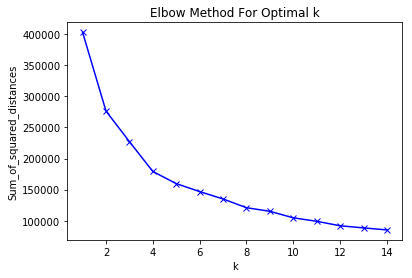

In [93]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

According to the plot, the "elbow" is at 4, hence this will be the number of clusters for the analysis.

In [94]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(cologne_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:4] 

array([3, 3, 3, 3], dtype=int32)

In [95]:
geo_analysis.insert(0, 'cluster labels', kmeans.labels_)

In [96]:
geo_analysis.head()

cluster labels  neighbourhood  no.     borough  \
0               3   Altstadt/Süd  101  Innenstadt   
1               3   Neustadt/Süd  102  Innenstadt   
2               3  Altstadt/Nord  103  Innenstadt   
3               3  Neustadt/Nord  104  Innenstadt   
4               0          Deutz  105  Innenstadt   

                                      geometry.rings   latitude  longitude  \
0  [[50.936798424501795, 6.940278401301003], [50....  50.930223   6.953587   
1  [[50.93748386396194, 6.9264717966942015], [50....  50.926103   6.946810   
2  [[50.95008808829535, 6.9589532284153925], [50....  50.942170   6.954201   
3  [[50.95928768013307, 6.9636858833452315], [50....  50.948038   6.948013   
4  [[50.94948568775351, 6.981916500484012], [50.9...  50.938282   6.980676   

   inhabitants/sqm  day nurseries pp    mv rate   car rate  p.car rate  \
0         0.011807          0.000430  46.191579  40.442648   28.128556   
1         0.013480          0.000725  41.481053  35.666763   29.953717   
2         0.007441          0.000493  68.354804  59.608793   29.216405   
3         0.008199          0.000804  59.043342  50.140570   34.666146   
4         0.003005          0.000826  69.130062  58.119903   31.678352   

   1 person hh per  2 person hh per  3 person hh per  4 person hh per  \
0             69.5             20.6              5.7              3.1   
1             66.8             21.0              6.8              4.1   
2             70.6             20.4              5.4              2.6   
3             65.3             21.8              7.3              4.6   
4             60.2             26.0              8.1              4.4   

   mt5 person hh per  single parent hh per  mcouple child hh per  \
0                1.1                   1.9                   4.8   
1                1.2                   2.5                   6.2   
2                0.9                   1.6                   4.4   
3                1.0                   2.1                   6.9   
4                1.4                   2.9                   7.1   

   mcouple no child hh per  couple child hh per  couple no child hh per  \
0                     12.3                  1.2                     6.0   
1                     10.7                  2.1                     7.7   
2                     11.9                  1.2                     6.2   
3                     13.4                  1.9                     6.6   
4                     16.2                  1.7                     7.0   

   other no child hh per  ur alg1 germans  ur alg1 women  ur alg1 all  \
0                    4.2         3.270990       3.211575     4.238441   
1                    4.0         2.436985       2.187418     3.139752   
2                    4.2         1.937897       1.899198     2.847161   
3                    3.7         1.701992       1.760598     2.146948   
4                    4.9         3.399355       3.205978     4.172247   

   ur alg1 men  ur alg1 below 25  ur hartz4 germans  ur hartz4 women  \
0     5.126187          2.808915           2.149301         2.220348   
1     4.004590          1.372338           2.084764         2.276337   
2     3.567507          2.463683           1.949501         2.191383   
3     2.491517          1.085149           2.070533         2.427110   
4     5.009600          2.315082           1.445703         1.408687   

   ur hartz41 all  ur hartz4 men  ur hartz4 below 25  AUSL1GEN_AP  \
0        2.255147       2.279591            1.053343         49.0   
1        2.219041       2.164424            0.640424         46.0   
2        2.094041       2.003668            1.285400         54.5   
3        2.230441       2.049839            1.168622         46.0   
4        1.614330       1.790666            1.041787         44.0   

   AUSL23GEN_AP  AUSLAENDER_AP  AUSLAND_AP  AUSSIEDLER_AP  A_18_30_AP  \
0          10.0           19.3        24.1            9.0        23.9   
1           8.0           15.1        

In [97]:
map_cologne = folium.Map(location=[latitude_cologne, longitude_cologne], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(geo['latitude'], geo_analysis['longitude'], geo_analysis['neighbourhood'], geo_analysis['cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_cologne)
       
map_cologne

After this interesting overview, I'll analyze the different clusters a little bit further.

In [98]:
# create dataframe for detail_analysis

geo_detail=geo_analysis.drop(['geometry.rings', 'latitude', 'longitude'], 1)

In [99]:
# creating dataframes for all clusters
cluster0 = geo_detail.loc[geo_detail['cluster labels'] == 0, geo_detail.columns[[] + list(range(0, geo_detail.shape[1]))]]
cluster1 = geo_detail.loc[geo_detail['cluster labels'] == 1, geo_detail.columns[[] + list(range(0, geo_detail.shape[1]))]]
cluster2 = geo_detail.loc[geo_detail['cluster labels'] == 2, geo_detail.columns[[] + list(range(0, geo_detail.shape[1]))]]
cluster3 = geo_detail.loc[geo_detail['cluster labels'] == 3, geo_detail.columns[[] + list(range(0, geo_detail.shape[1]))]]


In [100]:
cluster0.shape

(50, 328)

In [101]:
cluster0

cluster labels         neighbourhood  no.       borough  inhabitants/sqm  \
4                0                 Deutz  105    Innenstadt         0.003005   
6                0            Marienburg  202  Rodenkirchen         0.002300   
8                0             Raderthal  204  Rodenkirchen         0.001508   
10               0               Rondorf  206  Rodenkirchen         0.001172   
12               0          Rodenkirchen  208  Rodenkirchen         0.002243   
13               0                  Weiß  209  Rodenkirchen         0.001443   
14               0                 Sürth  210  Rodenkirchen         0.003183   
16               0             Immendorf  212  Rodenkirchen         0.000396   
22               0           Müngersdorf  305    Lindenthal         0.001719   
23               0           Junkersdorf  306    Lindenthal         0.001992   
24               0                Weiden  307    Lindenthal         0.004761   
25               0              Lövenich  308    Lindenthal         0.002466   
26               0           Widdersdorf  309    Lindenthal         0.002186   
30               0             Vogelsang  404     Ehrenfeld         0.002232   
31               0  Bocklemünd/Mengenich  405     Ehrenfeld         0.002169   
32               0             Ossendorf  406     Ehrenfeld         0.001556   
36               0                 Niehl  504        Nippes         0.001675   
37               0           Weidenpesch  505        Nippes         0.003585   
38               0             Longerich  506        Nippes         0.002235   
40               0             Merkenich  601    Chorweiler         0.000472   
41               0             Fühlingen  602    Chorweiler         0.000411   
43               0           Heimersdorf  604    Chorweiler         0.003528   
44               0            Lindweiler  605    Chorweiler         0.002976   
45               0                 Pesch  606    Chorweiler         0.002736   
46               0         Esch/Auweiler  607    Chorweiler         0.000916   
47               0      Volkhoven/Weiler  608    Chorweiler         0.001397   
50               0  Roggendorf/Thenhoven  611    Chorweiler         0.000320   
51               0             Worringen  612    Chorweiler         0.000881   
52               0                  Poll  701          Porz         0.002218   
53               0             Westhoven  702          Porz         0.001306   
54               0                 Ensen  703          Porz         0.004707   
56               0                   Eil  705          Porz         0.000566   
58               0                Urbach  707          Porz         0.005505   
59               0               Elsdorf  708          Porz         0.000970   
60               0               Grengel  709          Porz         0.000519   
61               0             Wahnheide  710          Porz         0.002733   
62               0                  Wahn  711          Porz         0.003178   
63               0                  Lind  712          Porz         0.001567   
64               0                 Libur  713          Porz         0.000178   
65               0               Zündorf  714          Porz         0.001463   
66               0                Langel  715          Porz         0.000653   
73               0               Merheim  806          Kalk         0.002946   
74               0                 Brück  807          Kalk         0.001387   
75               0           Rath/Heumar  808          Kalk         0.000913   
80               0              Holweide  904       Mülheim         0.005137   
81               0             Dellbrück  905       Mülheim         0.002192   
82               0             Höhenhaus  906       Mülheim         0.003080   
83               0              Dünnwald  907       Mülheim         0.001085   
84               0             Stammheim  908       Mülheim         0.002138   
85  

In [102]:
cluster1.shape

(17, 328)

In [103]:
cluster1

cluster labels      neighbourhood  no.       borough  inhabitants/sqm  \
17               1         Meschenich  213  Rodenkirchen         0.001681   
29               1         Bickendorf  403     Ehrenfeld         0.007139   
39               1    Bilderstöckchen  507        Nippes         0.004200   
42               1            Seeberg  603    Chorweiler         0.006409   
48               1         Chorweiler  609    Chorweiler         0.006895   
49               1         Blumenberg  610    Chorweiler         0.001710   
57               1               Porz  706          Porz         0.004785   
67               1         Finkenberg  716          Porz         0.010955   
68               1  Humboldt/Gremberg  801          Kalk         0.005498   
69               1               Kalk  802          Kalk         0.008110   
70               1             Vingst  803          Kalk         0.011654   
71               1          Höhenberg  804          Kalk         0.005772   
72               1            Ostheim  805          Kalk         0.003640   
76               1           Neubrück  809          Kalk         0.008197   
77               1            Mülheim  901       Mülheim         0.006055   
78               1          Buchforst  902       Mülheim         0.009082   
79               1           Buchheim  903       Mülheim         0.004530   

    day nurseries pp    mv rate   car rate  p.car rate  1 person hh per  \
17          0.000630  51.199217  44.330233   43.514440             31.4   
29          0.000725  51.267647  42.368246   39.226846             47.1   
39          0.000569  55.433581  47.393777   40.672879             42.9   
42          0.000701  43.823234  39.850463   39.404084             31.4   
48          0.000529  33.605028  31.189237   29.559069             28.3   
49          0.000726  60.721626  53.825074   53.254168             25.6   
57          0.000603  50.882734  45.602527   43.666991             44.0   
67          0.000573  48.311836  45.447648   33.782246             28.5   
68          0.000516  39.936645  35.749054   32.944449             54.0   
69          0.000582  36.550617  32.281529   27.239892             56.1   
70          0.000687  39.247312  35.650049   35.200391             38.8   
71          0.000553  38.900974  34.105741   33.282890             52.5   
72          0.000660  48.953655  43.019589   40.697563             35.9   
76          0.000556  46.564886  42.550184   41.800961             36.7   
77          0.000631  49.592372  43.171881   31.809078             54.3   
78          0.000795  38.568461  34.382489   33.807317             50.9   
79          0.000541  45.771850  40.077563   37.041241             47.6   

    2 person hh per  3 person hh per  4 person hh per  mt5 person hh per  \
17             31.1             14.2             12.3               11.0   
29             27.2             12.1              9.2                4.3   
39             27.3             13.2             10.9                5.8   
42             31.3             17.5             12.3                7.6   
48             30.9             18.2             13.0                9.5   
49             28.6             20.3             16.5                9.0   
57             29.3             12.6              9.5                4.6   
67             31.5             16.1             11.2               12.6   
68             24.5             10.5              6.7                4.3   
69             23.2              9.7              6.7                4.3   
70             28.0             14.4             11.4                7.3   
71             25.6             10.7              7.4                3.7   
72             28.3             15.6             12.0                8.2   
76             31.1             13.6             11.0                7.7   
77             24.4             10.3              7.2                3.8   
78             26.5             11.0              

In [104]:
cluster2.shape

(3, 328)

In [105]:
cluster2

cluster labels  neighbourhood  no.       borough  inhabitants/sqm  \
11               2       Hahnwald  207  Rodenkirchen         0.000687   
15               2         Godorf  211  Rodenkirchen         0.000555   
55               2  Gremberghoven  704          Porz         0.000512   

    day nurseries pp     mv rate    car rate  p.car rate  1 person hh per  \
11          0.000000  226.493663  171.152686   94.508147             32.4   
15          0.000785  133.091787   99.613527   55.893720             40.8   
55          0.001303  158.865848  141.303428   38.637325             39.4   

    2 person hh per  3 person hh per  4 person hh per  mt5 person hh per  \
11             32.8             16.5             12.5                5.8   
15             31.9             13.6              9.2                4.5   
55             28.0             14.4             10.4                7.8   

    single parent hh per  mcouple child hh per  mcouple no child hh per  \
11                   3.1                  20.9                     35.4   
15                   4.2                  14.6                     28.2   
55                   6.9                  17.1                     25.3   

    couple child hh per  couple no child hh per  other no child hh per  \
11                  1.4                     1.8                    4.9   
15                  2.0                     4.3                    5.9   
55                  3.1                     2.3                    5.9   

    ur alg1 germans  ur alg1 women  ur alg1 all  ur alg1 men  \
11         0.905626       0.414765     0.916317     1.401864   
15         5.135537       6.887176     6.510284     6.168203   
55        13.471609      12.838340    14.579585    15.936436   

    ur alg1 below 25  ur hartz4 germans  ur hartz4 women  ur hartz41 all  \
11          0.000000           0.566016         0.414765        0.509065   
15          6.543249           1.643372         1.511819        1.589721   
55          8.561661           1.940825         1.255925        1.830338   

    ur hartz4 men  ur hartz4 below 25  AUSL1GEN_AP  AUSL23GEN_AP  \
11       0.600799            0.986074         48.6           3.3   
15       1.644854            0.817906         49.7          13.4   
55       2.293012            4.029017         47.6          14.8   

    AUSLAENDER_AP  AUSLAND_AP  AUSSIEDLER_AP  A_18_30_AP  A_30_65_AP  \
11           12.1        19.8           10.9        10.7        47.2   
15           27.1        29.3            8.0        13.5        51.0   
55           43.9        43.5            4.3        16.6        46.2   

    A_65_80_AP  A_AB_80_AP  A_U_18_AP  BALKANGRUPPE_AP  BULGARIEN_AP  \
11        17.5         5.1       19.5             41.7           3.6   
15        12.4         4.3       18.7             70.0           2.6   
55        10.2         4.1       23.0             72.0           1.3   

    DEUTSCHE_AP  DEUTSCHE_MHG_AP  DEUTSCHLAND_AP  EHEMUDSSR_AP  \
11         76.7             11.2            44.8          35.0   
15         57.0             15.9            32.3           8.4   
55         29.7             26.4            20.3          14.4   

    EINGEBUERGERTE_AP  EVANGELISCH_AP  EWD_AP  FORTZUG_AP  FORTZUG_BINNEN_AP  \
11               35.5            17.4     6.9         4.8                4.5   
15               23.1            11.5     5.5         6.4                7.7   
55               24.5             7.7     5.1         5.2                5.4   

    GESCHIEDEN_AP  GRIECHENLAND_AP  HAUPTWOHNUNG_AP  ITALIEN_AP  \
11            4.6              3.6             99.5         2.0   
15            7.1              4.3             99.5         5.6   
55            7.2              2.3             99.8         5.4   

    KATHOLISCH_AP  KEINMIGRA_AP  KINDER_AP  KOELN_AP  LEBENSPS_AP  LEDIG_AP  \
11           36.9          76.7        1.3      35.5          0.4      37.5   
15           39.9          57.0        1.2      38.4          0.1      42

In [106]:
cluster3.shape

(16, 328)

In [107]:
cluster3

cluster labels  neighbourhood  no.       borough  inhabitants/sqm  \
0                3   Altstadt/Süd  101    Innenstadt         0.011807   
1                3   Neustadt/Süd  102    Innenstadt         0.013480   
2                3  Altstadt/Nord  103    Innenstadt         0.007441   
3                3  Neustadt/Nord  104    Innenstadt         0.008199   
5                3      Bayenthal  201  Rodenkirchen         0.007744   
7                3      Raderberg  203  Rodenkirchen         0.007534   
9                3      Zollstock  205  Rodenkirchen         0.004555   
18               3    Klettenberg  301    Lindenthal         0.005947   
19               3           Sülz  302    Lindenthal         0.007090   
20               3     Lindenthal  303    Lindenthal         0.003964   
21               3     Braunsfeld  304    Lindenthal         0.007182   
27               3      Ehrenfeld  401     Ehrenfeld         0.010186   
28               3   Neuehrenfeld  402     Ehrenfeld         0.009577   
33               3         Nippes  501        Nippes         0.012199   
34               3      Mauenheim  502        Nippes         0.011574   
35               3          Riehl  503        Nippes         0.004998   

    day nurseries pp    mv rate   car rate  p.car rate  1 person hh per  \
0           0.000430  46.191579  40.442648   28.128556             69.5   
1           0.000725  41.481053  35.666763   29.953717             66.8   
2           0.000493  68.354804  59.608793   29.216405             70.6   
3           0.000804  59.043342  50.140570   34.666146             65.3   
5           0.000704  64.860681  58.502024   42.879257             51.8   
7           0.000793  57.100149  45.403587   38.733184             53.9   
9           0.000393  49.102217  42.882937   37.210352             55.9   
18          0.000375  53.173280  46.871179   44.503723             52.4   
19          0.000600  57.332792  51.502762   37.654880             61.5   
20          0.000755  52.081855  47.051794   41.704321             59.8   
21          0.000414  70.717493  60.666858   44.425337             56.0   
27          0.000687  49.909910  40.243243   29.921922             63.6   
28          0.000369  48.091382  39.931560   37.102371             55.8   
33          0.000930  41.241843  35.536603   34.350972             56.8   
34          0.000707  50.253378  43.158784   42.377534             52.6   
35          0.000586  48.269880  42.438554   39.065060             51.8   

    2 person hh per  3 person hh per  4 person hh per  mt5 person hh per  \
0              20.6              5.7              3.1                1.1   
1              21.0              6.8              4.1                1.2   
2              20.4              5.4              2.6                0.9   
3              21.8              7.3              4.6                1.0   
5              27.5             10.7              7.3                2.7   
7              26.2             10.2              6.8                2.9   
9              26.5              9.3              6.1                2.2   
18             26.8             10.6              7.8                2.4   
19             23.5              7.8              5.6                1.6   
20             24.0              8.9              5.5                1.8   
21             26.5              9.5              6.1                1.9   
27             21.5              8.1              4.9                1.9   
28             25.0             10.0              6.8                2.3   
33             24.0              9.9              7.1                2.3   
34             25.4             11.1              8.0                2.9   
35             28.8             10.6              6.8                1.9   

    single parent hh per  mcouple child hh per  mcouple no child hh per  \
0                    1.9                   4.8                     12.3   
1                    2.5                   

Because it's hard to compare the clusters with all the rows, I create another table. This table contains the mean of each variable per cluster. The table cluster_compare then delivers a superficial first overview on the clusters:

In [108]:
# compare clusters:

cluster_compare = geo_detail.groupby(geo_detail['cluster labels']).mean()
cluster_compare = cluster_compare.drop('no.', 1)

In [109]:
cluster_compare

inhabitants/sqm  day nurseries pp     mv rate    car rate  \
cluster labels                                                              
0                      0.002019          0.000623   73.821871   62.984093   
1                      0.006254          0.000622   45.843040   40.646781   
2                      0.000585          0.000696  172.817100  137.356547   
3                      0.008342          0.000610   53.575352   46.253041   

                p.car rate  1 person hh per  2 person hh per  3 person hh per  \
cluster labels                                                                  
0                55.095101        40.662000        31.352000        13.866000   
1                37.464971        41.529412        27.970588        13.682353   
2                63.013064        37.533333        30.900000        14.833333   
3                36.993359        59.006250        24.343750         8.868750   

                4 person hh per  mt5 person hh per  single parent hh per  \
cluster labels                                                             
0                     10.110000           4.006000              4.756000   
1                     10.235294           6.570588              6.264706   
2                     10.700000           6.033333              4.733333   
3                      5.825000           1.937500              3.100000   

                mcouple child hh per  mcouple no child hh per  \
cluster labels                                                  
0                          15.296000                27.964000   
1                          15.576471                23.676471   
2                          17.533333                29.633333   
3                           9.200000                16.106250   

                couple child hh per  couple no child hh per  \
cluster labels                                                
0                          2.098000                3.806000   
1                          2.600000                4.047059   
2                          2.166667                2.800000   
3                          1.968750                6.350000   

                other no child hh per  ur alg1 germans  ur alg1 women  \
cluster labels                                                          
0                            5.416000         3.662873       4.915042   
1                            6.311765         8.480718      11.450542   
2                            5.566667         6.504257       6.713427   
3                            4.250000         2.467417       2.694176   

                ur alg1 all  ur alg1 men  ur alg1 below 25  ur hartz4 germans  \
cluster labels                                                                  
0                  4.822719     4.732908          2.681694           1.724146   
1                 10.954190    10.459095          4.826548           1.960377   
2                  7.335395     7.835501          5.034970           1.383404   
3                  3.249486     3.763269          1.588152           1.816906   

                ur hartz4 women  ur hartz41 all  ur hartz4 men  \
cluster labels                                                   
0                      1.749308        1.886191       2.015841   
1                      1.907757        2.262333       2.579397   
2                      1.060836        1.309708       1.512888   
3                      2.071798        2.010155       1.953683   

                ur hartz4 below 25  AUSL1GEN_AP  AUSL23GEN_AP  AUSLAENDER_AP  \
cluster labels                                                                 
0                         1.523955    33.534000     10.000000      14.760000   
1                         2.141594    40.088235     12.317647      32.164706   
2                         1.944332    48.633333     10.500000      27.700000   
3                         0.995652    42.906250      9.018750      15.518750   

                AUSLAND_AP  AUSSIED

To be able to see if it's possible to have the same living experience in another neighbourhood than the popular neighbourhoods but within the same cluster, I'll add the rent index to each cluster table.

In [110]:
# get the data from the webseite
website_url = requests.get('https://www.koeln.de/immobilien/mietspiegel.html').text

In [111]:
# transform it into a dataframe
rent_index = pd.read_html(website_url, header = 0)[0]

In [112]:
rent_index.head()

Stadtteil 4. Quartal 2018/04 3. Quartal 2018 Veränderung
0  Altstadt-Nord            10,70 €         10,50 €        1,9%
1   Altstadt-Süd            12,20 €         12,20 €        0,0%
2       Auweiler             8,60 €          8,60 €        0,0%
3      Bayenthal            11,90 €         11,80 €        0,8%
4     Bickendorf            10,40 €         10,30 €        1,0%

In [113]:
rent_index = rent_index.rename(columns = {'Stadtteil' : 'neighbourhood', '4. Quartal 2018/04' : '4q2018'})
# drop unnecessary columns
rent_index = rent_index.drop(['3. Quartal 2018', 'Veränderung'], 1)

In [114]:
# rename columns to allow for merging with the cluster table and making the rent a sortable float
rent_index['neighbourhood'] = rent_index['neighbourhood'].str.replace('-', '/')
rent_index['4q2018'] = rent_index['4q2018'].str.replace(' €', '')
rent_index['4q2018'] = rent_index['4q2018'].str.replace(',', '.')
rent_index['4q2018'] = rent_index['4q2018'].astype('float')

In [115]:
rent_index.head()

neighbourhood  4q2018
0  Altstadt/Nord    10.7
1   Altstadt/Süd    12.2
2       Auweiler     8.6
3      Bayenthal    11.9
4     Bickendorf    10.4

In [116]:
rent_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
neighbourhood    86 non-null object
4q2018           86 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [117]:
cluster0 = cluster0.merge(rent_index, on = 'neighbourhood')

# move rent_index column to the first column
fixed_columns = [cluster0.columns[-1]] + list(cluster0.columns[:-1])
cluster0 = cluster0[fixed_columns]

In [118]:
cluster0.sort_values(by = ['4q2018'])

4q2018  cluster labels         neighbourhood  no.       borough  \
24     8.6               0      Volkhoven/Weiler  608    Chorweiler   
32     8.6               0               Elsdorf  708          Porz   
31     8.6               0                Urbach  707          Porz   
26     8.7               0             Worringen  612    Chorweiler   
25     8.7               0  Roggendorf/Thenhoven  611    Chorweiler   
20     8.7               0             Fühlingen  602    Chorweiler   
19     8.7               0             Merkenich  601    Chorweiler   
37     8.8               0                 Libur  713          Porz   
36     8.8               0                  Lind  712          Porz   
35     8.8               0                  Wahn  711          Porz   
34     8.8               0             Wahnheide  710          Porz   
33     8.8               0               Grengel  709          Porz   
30     8.8               0                   Eil  705          Porz   
45     8.9               0             Höhenhaus  906       Mülheim   
47     8.9               0             Stammheim  908       Mülheim   
48     8.9               0              Flittard  909       Mülheim   
28     9.0               0             Westhoven  702          Porz   
29     9.0               0                 Ensen  703          Porz   
21     9.0               0           Heimersdorf  604    Chorweiler   
22     9.0               0            Lindweiler  605    Chorweiler   
23     9.0               0                 Pesch  606    Chorweiler   
38     9.1               0               Zündorf  714          Porz   
41     9.1               0                 Brück  807          Kalk   
39     9.1               0                Langel  715          Porz   
40     9.1               0               Merheim  806          Kalk   
42     9.2               0           Rath/Heumar  808          Kalk   
46     9.3               0              Dünnwald  907       Mülheim   
44     9.3               0             Dellbrück  905       Mülheim   
3      9.3               0               Rondorf  206  Rodenkirchen   
2      9.3               0             Raderthal  204  Rodenkirchen   
7      9.3               0             Immendorf  212  Rodenkirchen   
43     9.4               0              Holweide  904       Mülheim   
13     9.7               0             Vogelsang  404     Ehrenfeld   
14     9.7               0  Bocklemünd/Mengenich  405     Ehrenfeld   
15     9.7               0             Ossendorf  406     Ehrenfeld   
11     9.9               0              Lövenich  308    Lindenthal   
10     9.9               0                Weiden  307    Lindenthal   
12     9.9               0           Widdersdorf  309    Lindenthal   
27    10.0               0                  Poll  701          Porz   
18    10.1               0             Longerich  506        Nippes   
17    10.1               0           Weidenpesch  505        Nippes   
16    10.6               0                 Niehl  504        Nippes   
5     10.6               0                  Weiß  209  Rodenkirchen   
6     10.6               0                 Sürth  210  Rodenkirchen   
4     11.1               0          Rodenkirchen  208  Rodenkirchen   
0     11.3               0                 Deutz  105    Innenstadt   
9     11.4               0           Junkersdorf  306    Lindenthal   
8     11.9               0           Müngersdorf  305    Lindenthal   
1     11.9               0            Marienburg  202  Rodenkirchen   

    inhabitants/sqm  day nurseries pp     mv rate   car rate  p.car rate  \
24         0.001397          0.000658   78.766701  71.038027   53.401850   
32         0.000970          0.001168   68.402025  58.206797   56.688359   
31         0.005505          0.000476   58.839303  52.671902   51.120475   
26         0.000881          0.000581   66.893019  57.850846   56.385513   
25         0.000320          0.000682   64.509635  56.744320   56.197872 

In [119]:
cluster1 = cluster1.merge(rent_index, on = 'neighbourhood')

# move rent_index column to the first column
fixed_columns = [cluster1.columns[-1]] + list(cluster1.columns[:-1])
cluster1 = cluster1[fixed_columns]

cluster1.sort_values(by = ['4q2018'])

4q2018  cluster labels      neighbourhood  no.       borough  \
4      8.6               1         Chorweiler  609    Chorweiler   
5      8.6               1         Blumenberg  610    Chorweiler   
3      8.7               1            Seeberg  603    Chorweiler   
7      9.0               1         Finkenberg  716          Porz   
13     9.1               1           Neubrück  809          Kalk   
6      9.1               1               Porz  706          Porz   
12     9.2               1            Ostheim  805          Kalk   
10     9.2               1             Vingst  803          Kalk   
0      9.3               1         Meschenich  213  Rodenkirchen   
16     9.4               1           Buchheim  903       Mülheim   
11     9.6               1          Höhenberg  804          Kalk   
9      9.6               1               Kalk  802          Kalk   
15     9.8               1          Buchforst  902       Mülheim   
2      9.9               1    Bilderstöckchen  507        Nippes   
8     10.0               1  Humboldt/Gremberg  801          Kalk   
1     10.4               1         Bickendorf  403     Ehrenfeld   
14    10.4               1            Mülheim  901       Mülheim   

    inhabitants/sqm  day nurseries pp    mv rate   car rate  p.car rate  \
4          0.006895          0.000529  33.605028  31.189237   29.559069   
5          0.001710          0.000726  60.721626  53.825074   53.254168   
3          0.006409          0.000701  43.823234  39.850463   39.404084   
7          0.010955          0.000573  48.311836  45.447648   33.782246   
13         0.008197          0.000556  46.564886  42.550184   41.800961   
6          0.004785          0.000603  50.882734  45.602527   43.666991   
12         0.003640          0.000660  48.953655  43.019589   40.697563   
10         0.011654          0.000687  39.247312  35.650049   35.200391   
0          0.001681          0.000630  51.199217  44.330233   43.514440   
16         0.004530          0.000541  45.771850  40.077563   37.041241   
11         0.005772          0.000553  38.900974  34.105741   33.282890   
9          0.008110          0.000582  36.550617  32.281529   27.239892   
15         0.009082          0.000795  38.568461  34.382489   33.807317   
2          0.004200          0.000569  55.433581  47.393777   40.672879   
8          0.005498          0.000516  39.936645  35.749054   32.944449   
1          0.007139          0.000725  51.267647  42.368246   39.226846   
14         0.006055          0.000631  49.592372  43.171881   31.809078   

    1 person hh per  2 person hh per  3 person hh per  4 person hh per  \
4              28.3             30.9             18.2             13.0   
5              25.6             28.6             20.3             16.5   
3              31.4             31.3             17.5             12.3   
7              28.5             31.5             16.1             11.2   
13             36.7             31.1             13.6             11.0   
6              44.0             29.3             12.6              9.5   
12             35.9             28.3             15.6             12.0   
10             38.8             28.0             14.4             11.4   
0              31.4             31.1             14.2             12.3   
16             47.6             26.7             12.6              8.7   
11             52.5             25.6             10.7              7.4   
9              56.1             23.2              9.7              6.7   
15             50.9             26.5             11.0              8.0   
2              42.9             27.3             13.2             10.9   
8              54.0             24.5             10.5              6.7   
1              47.1             27.2             12.1              9.2   
14             54.3             24.4             10.3              7.2   

    mt5 person hh per  single parent hh per  mcouple child hh per  \
4                 9.5     

In [120]:
cluster2 = cluster2.merge(rent_index, on = 'neighbourhood')

# move rent_index column to the first column
fixed_columns = [cluster2.columns[-1]] + list(cluster2.columns[:-1])
cluster2 = cluster2[fixed_columns]

cluster2.sort_values(by = ['4q2018'])

4q2018  cluster labels  neighbourhood  no.       borough  inhabitants/sqm  \
2     9.0               2  Gremberghoven  704          Porz         0.000512   
1     9.3               2         Godorf  211  Rodenkirchen         0.000555   
0    11.1               2       Hahnwald  207  Rodenkirchen         0.000687   

   day nurseries pp     mv rate    car rate  p.car rate  1 person hh per  \
2          0.001303  158.865848  141.303428   38.637325             39.4   
1          0.000785  133.091787   99.613527   55.893720             40.8   
0          0.000000  226.493663  171.152686   94.508147             32.4   

   2 person hh per  3 person hh per  4 person hh per  mt5 person hh per  \
2             28.0             14.4             10.4                7.8   
1             31.9             13.6              9.2                4.5   
0             32.8             16.5             12.5                5.8   

   single parent hh per  mcouple child hh per  mcouple no child hh per  \
2                   6.9                  17.1                     25.3   
1                   4.2                  14.6                     28.2   
0                   3.1                  20.9                     35.4   

   couple child hh per  couple no child hh per  other no child hh per  \
2                  3.1                     2.3                    5.9   
1                  2.0                     4.3                    5.9   
0                  1.4                     1.8                    4.9   

   ur alg1 germans  ur alg1 women  ur alg1 all  ur alg1 men  ur alg1 below 25  \
2        13.471609      12.838340    14.579585    15.936436          8.561661   
1         5.135537       6.887176     6.510284     6.168203          6.543249   
0         0.905626       0.414765     0.916317     1.401864          0.000000   

   ur hartz4 germans  ur hartz4 women  ur hartz41 all  ur hartz4 men  \
2           1.940825         1.255925        1.830338       2.293012   
1           1.643372         1.511819        1.589721       1.644854   
0           0.566016         0.414765        0.509065       0.600799   

   ur hartz4 below 25  AUSL1GEN_AP  AUSL23GEN_AP  AUSLAENDER_AP  AUSLAND_AP  \
2            4.029017         47.6          14.8           43.9        43.5   
1            0.817906         49.7          13.4           27.1        29.3   
0            0.986074         48.6           3.3           12.1        19.8   

   AUSSIEDLER_AP  A_18_30_AP  A_30_65_AP  A_65_80_AP  A_AB_80_AP  A_U_18_AP  \
2            4.3        16.6        46.2        10.2         4.1       23.0   
1            8.0        13.5        51.0        12.4         4.3       18.7   
0           10.9        10.7        47.2        17.5         5.1       19.5   

   BALKANGRUPPE_AP  BULGARIEN_AP  DEUTSCHE_AP  DEUTSCHE_MHG_AP  \
2             72.0           1.3         29.7             26.4   
1             70.0           2.6         57.0             15.9   
0             41.7           3.6         76.7             11.2   

   DEUTSCHLAND_AP  EHEMUDSSR_AP  EINGEBUERGERTE_AP  EVANGELISCH_AP  EWD_AP  \
2            20.3          14.4               24.5             7.7     5.1   
1            32.3           8.4               23.1            11.5     5.5   
0            44.8          35.0               35.5            17.4     6.9   

   FORTZUG_AP  FORTZUG_BINNEN_AP  GESCHIEDEN_AP  GRIECHENLAND_AP  \
2         5.2                5.4            7.2              2.3   
1         6.4                7.7            7.1              4.3   
0         4.8                4.5            4.6              3.6   

   HAUPTWOHNUNG_AP  ITALIEN_AP  KATHOLISCH_AP  KEINMIGRA_AP  KINDER_AP  \
2             99.8         5.4           21.3          29.7        0.8   
1             99.5         5.6           39.9          57.0        1.2   
0             99.5         2.0           36.9          76.7        1.3   

   KOELN_AP  LEBENSPS_AP  LEDIG_AP  MAENNLICH_AP  MIGRA_AP  NEBENWOHNUNG_AP  \
2      36.1

In [121]:
cluster3 = cluster3.merge(rent_index, on = 'neighbourhood')

# move rent_index column to the first column
fixed_columns = [cluster3.columns[-1]] + list(cluster3.columns[:-1])
cluster3 = cluster3[fixed_columns]

cluster3.sort_values(by = ['4q2018'])

4q2018  cluster labels  neighbourhood  no.       borough  inhabitants/sqm  \
14     9.9               3      Mauenheim  502        Nippes         0.011574   
15    10.6               3          Riehl  503        Nippes         0.004998   
2     10.7               3  Altstadt/Nord  103    Innenstadt         0.007441   
6     11.2               3      Zollstock  205  Rodenkirchen         0.004555   
4     11.9               3      Bayenthal  201  Rodenkirchen         0.007744   
5     11.9               3      Raderberg  203  Rodenkirchen         0.007534   
10    11.9               3     Braunsfeld  304    Lindenthal         0.007182   
13    11.9               3         Nippes  501        Nippes         0.012199   
8     12.0               3           Sülz  302    Lindenthal         0.007090   
7     12.1               3    Klettenberg  301    Lindenthal         0.005947   
11    12.1               3      Ehrenfeld  401     Ehrenfeld         0.010186   
12    12.1               3   Neuehrenfeld  402     Ehrenfeld         0.009577   
0     12.2               3   Altstadt/Süd  101    Innenstadt         0.011807   
9     12.3               3     Lindenthal  303    Lindenthal         0.003964   
3     12.4               3  Neustadt/Nord  104    Innenstadt         0.008199   
1     12.9               3   Neustadt/Süd  102    Innenstadt         0.013480   

    day nurseries pp    mv rate   car rate  p.car rate  1 person hh per  \
14          0.000707  50.253378  43.158784   42.377534             52.6   
15          0.000586  48.269880  42.438554   39.065060             51.8   
2           0.000493  68.354804  59.608793   29.216405             70.6   
6           0.000393  49.102217  42.882937   37.210352             55.9   
4           0.000704  64.860681  58.502024   42.879257             51.8   
5           0.000793  57.100149  45.403587   38.733184             53.9   
10          0.000414  70.717493  60.666858   44.425337             56.0   
13          0.000930  41.241843  35.536603   34.350972             56.8   
8           0.000600  57.332792  51.502762   37.654880             61.5   
7           0.000375  53.173280  46.871179   44.503723             52.4   
11          0.000687  49.909910  40.243243   29.921922             63.6   
12          0.000369  48.091382  39.931560   37.102371             55.8   
0           0.000430  46.191579  40.442648   28.128556             69.5   
9           0.000755  52.081855  47.051794   41.704321             59.8   
3           0.000804  59.043342  50.140570   34.666146             65.3   
1           0.000725  41.481053  35.666763   29.953717             66.8   

    2 person hh per  3 person hh per  4 person hh per  mt5 person hh per  \
14             25.4             11.1              8.0                2.9   
15             28.8             10.6              6.8                1.9   
2              20.4              5.4              2.6                0.9   
6              26.5              9.3              6.1                2.2   
4              27.5             10.7              7.3                2.7   
5              26.2             10.2              6.8                2.9   
10             26.5              9.5              6.1                1.9   
13             24.0              9.9              7.1                2.3   
8              23.5              7.8              5.6                1.6   
7              26.8             10.6              7.8                2.4   
11             21.5              8.1              4.9                1.9   
12             25.0             10.0              6.8                2.3   
0              20.6              5.7              3.1                1.1   
9              24.0              8.9              5.5                1.8   
3              21.8              7.3              4.6                1.0   
1              21.0              6.8              4.1                1.2   

    single parent hh per  mcouple child hh per  mcouple n

## Results and Discussion <a name="results"></a>

### General results
The analysis identifies 4 neighbourhood clusters for the city of Cologne:
* Cluster 0 with 50 neighbourhoods
* Cluster 1 with 17 neighbourhoods
* Cluster 2 with 3 neighbourhoods
* Cluster 3 with 16 neighbourhoods

They are located on the map as follows:

In [122]:
map_cologne

The neighbourhoods of **cluster 0** (coloured red on the map) are mainly the outer suburbs of Cologne. Compared to the other clusters, the neighbourhoods in cluster 0 are pretty medium with regard to population density and household structure. The neighbourhoods have a lower percentage of foreigners and the people are more catholic and older, which is also reflected in the higher rate of widowed persons. They can be classified as typical middle-class neighbourhoods.

The neighbourhoods of **cluster 1** (coloured in purple on the map) are mainly located on the left bank of the river Rhine and in the north of the city. These neighbourhoods could rather be classified as the problem areas of the city. Compared to the other clusters, the neighbourhoods in this cluster reveal a higher rate of single parents, a higher unemployment rate, a higher rate of foreigners, more lower education schools and a higher amount of car related venues such as workshops.

The neighbourhoods of **cluster 2** (coloured in turquoise on the map) have the lowest population density, an unsually high motorvehicle registration rate and very few restaurants. In these neighbourhoods we have a large refinery and a business park. Hence, cluster 2 represents the industrial neighbourhoods.

The neighbourhoods of **cluster 3** (coloured in ochre on the map) are the most popular and central ones. Here, we have the highest rate of single households, the lowest rate of households with children, the highest population density, the lowest unemployment rates, the highest rate of same-sex couples, a higher fluctuation (on average a quarter of the people live there for less than 2 years), the highest rates of in-migration, more higher-education schools and the most restaurants and bars. Cluster 3 represents the young and liberal city center.

For people that move to Cologne, this general cluster overview is helpful to identify the neighbourhoods where they might want to live and where they could look for apartments.

### Rental cost savings results
For people moving to Cologne, the general results of the analysis are helpful to find a cluster of similar neighbourhoods to move to. However, when it comes to finding an apartment, it's helpful to additionally consider the rent index. That allows to move to a similar neighbourhood with a similar lifestyle experience but paying less.

The most popular neighbourhoods are in cluster 3. The difference in the rent per sqm is up to 2 € (per sqm) between the different neighbourhoods of this cluster. Assuming you want to rent a 60sqm apartment, you can save 120 € per month by living in Mauenheim instead of Neustadt/Süd and still have a similar living experience.

In cluster 0, it's even possible to save up to 3,30 € per sqm, depending on the neighboorhoud you're living in.

## Conclusion <a name="conclusion"></a>

Cologne with its 86 neighbourhoods can be clustered in 4 different clusters:
* middle class neighbourhoods
* problem area neighbourhoods
* industrial neighbourhoods
* young and liberal city center neighbourhoods

Within these clusters, the rental prices for apartments can differ substantially between the neighbourhoods. The analysis shows that there's a chance to pay less rent but have a similar living experience if one person moves to another neighbourhood within one cluster.


The analysis has some drawbacks to be kept in mind:

The Foursquare data is not a very good data source for Germany (Cologne), since quite a bunch of venues are missing.
The socio-economic data used for the analysis are not all from or relevant for the same date and time.
For a more accurate result, other data sources (e.g. the crime statistics) should be included as well.
The k-means algorithm as used here can result in different clusters because of the random approch of the unsupervised machine learning. However, I ran the analysis many times and the algorithm gave me the same clusters.

Further research and segmentating of Cologne and its neighbourhoods should try to enrich the data used for clustering and maybe try different clustering methods.